In [113]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

In [105]:
import time
import json
import os
from tqdm import tqdm
from MaterialHandlingSchedulingProblemSolvers import MHSP_Benchmark, CP_Solver, IP_Solver, DE_Solver
import pickle


def get_next_benchmark(FOLDER):
    NETWORKs = os.listdir(FOLDER)
    NETWORKs = sorted([s for s in NETWORKs if s.startswith("Network")])
    print(NETWORKs)
    for networks in NETWORKs:
        for net in sorted(os.listdir(os.path.join(FOLDER,networks))):
            if net.startswith("network"):
                NETWORK = net
                JOB_FILE = [s for s in os.listdir(os.path.join(FOLDER,networks,NETWORK)) if s.startswith("Flexible")][0]
                FILENAME = os.path.join(FOLDER,networks,NETWORK,JOB_FILE)
                print(FILENAME)
                with open(FILENAME) as f:
                    data = json.loads(f.read())
                with open(os.path.join(FOLDER,networks,NETWORK,"Network config.json")) as f:
                    data.update(json.loads(f.read()))
                yield data, networks, NETWORK

def get_benchmark(FOLDER, networks, NETWORK):
    JOB_FILE = [s for s in os.listdir(os.path.join(FOLDER,networks,NETWORK)) if s.startswith("Flexible")][0]
    FILENAME = os.path.join(FOLDER,networks,NETWORK,JOB_FILE)
    print(FILENAME)
    with open(FILENAME) as f:
        data = json.loads(f.read())
    with open(os.path.join(FOLDER,networks,NETWORK,"Network config.json")) as f:
        data.update(json.loads(f.read()))
    return data, networks, NETWORK

def get_next_network(FOLDER):
    NETWORKs = os.listdir(FOLDER)
    NETWORKs = sorted([s for s in NETWORKs if s.startswith("Network")])
    print(NETWORKs)
    for networks in NETWORKs:
        for net in sorted(os.listdir(os.path.join(FOLDER,networks))):
            if net.startswith("network"):
                NETWORK = net
                yield networks, NETWORK
            
def get_time():
    return time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

def solve(path, Benchmark, fixed, inf):
    if fixed:
        Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 1, factor=2)
    else:
        Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 60, factor=3)
    
    Benchmark.InfCapacity = inf
    text = "fixed" if fixed else "flexible"
    text += " inf" if inf else " finite"
    print(get_time(), text)
    
    # try:
    #     if not os.path.exists(os.path.join(path,f"CP {text}.pkl")):
    #         CP = CP_Solver(Benchmark)
    #         msol = CP.Solve()
    #         print("CP", msol.get_objective_value(), msol.get_solve_time())
    #         with open(os.path.join(path,f"CP {text}.pkl"), "bw") as f:
    #             pickle.dump(msol, f)
    # except:
    #     pass
    
    # try:
    #     if not os.path.exists(os.path.join(path,f"IP {text} sol.json")):
    #         IP = IP_Solver(Benchmark)
    #         msol, mdl = IP.Solve()
    #         s = msol.export_as_json_string()
    #         s = json.loads(s)
    #         s.update({"time":mdl.solve_details.time})
    #         s = json.dumps(s)
    #         with open(os.path.join(path,f"IP {text} sol.json"), "w") as f:
    #             f.write(s)
    #         print("IP", mdl.objective_value, mdl.solve_details.time)
    # except:
    #     pass
    
    try:
        if not os.path.exists(os.path.join(path,f"DE {text} extended.pkl")):
            DE = DE_Solver(Benchmark)
            best, msol = DE.Solve(5, 100000, 60)
            print("DE Best", best)
            with open(os.path.join(path,f"DE {text} extended.pkl"), "bw") as f:
                pickle.dump(msol, f)
    except:
        pass
            
# if __name__ == "__main__":
           
        # solve(path, Benchmark, fixed=True, inf=True)
        # solve(path, Benchmark, fixed=True, inf=False)
        # solve(path, Benchmark, fixed=False, inf=True)
        # solve(path, Benchmark, fixed=False, inf=False)    


In [5]:
def result_validation(path, fixed, inf, random_one = False, id = None):
    text = "fixed" if fixed else "flexible"
    text += " random one" if random_one else ""
    text += " inf" if inf else " finite"
    text += f" {id}" if id is not None else ""
    
    # print(get_time(), text)
    
    cp_best = -1

    if os.path.exists(os.path.join(path,f"CP {text}.pkl")):
        with open(os.path.join(path,f"CP {text}.pkl"), "br") as f:
            cp_msol = pickle.load(f)
        if cp_msol.get_solve_time() < 60:
            cp_best = round(cp_msol.get_objective_value())
            
    if os.path.exists(os.path.join(path,f"IP {text} sol.json")):
        with open(os.path.join(path,f"IP {text} sol.json"), "br") as f:
            msol = json.load(f)
            # msol = pickle.load(f)
        obj = round(float(msol["CPLEXSolution"]["header"]["objectiveValue"]))
        solve_time = msol["time"]
        if solve_time < 60 and cp_best != -1:
            # if round(float(obj)) < cp_best:
            #     print(path, text)
            #     print(obj, cp_best, solve_time)
            assert round(float(obj)) == cp_best
    
    if os.path.exists(os.path.join(path,f"DE {text}.pkl")):
        with open(os.path.join(path,f"DE {text}.pkl"), "br") as f:
            msol = pickle.load(f)
        
        obj = min([r[1] for r in msol])
        assert round(obj) >= cp_best
        if cp_best != -1 and round(obj) < cp_best:
            print(obj, cp_best, cp_msol.get_solve_time())

In [6]:
# result validation
FOLDER = "Thesis Benchmark (Reachability not Guaranteed) Results (Special Case)"
# FOLDER = "Thesis Benchmark Results"
for networks, NETWORK in get_next_network(FOLDER):
    # Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    result_validation(path, fixed=True, inf=False)
    for i in range(10):
        result_validation(path, fixed=True, inf=False, random_one = True, id = i+1)
    result_validation(path, fixed=False, inf=False)
    # print(path)
    
    

['Network N12S48PD50C3']


In [26]:
def get_result(result, path, fixed, inf, random_one = False, id = None):
# def get_result(result, path, Benchmark, fixed, inf):
    # if fixed:
    #     Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 1, factor=2)
    # else:
    #     Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 30, factor=2)
    
    # Benchmark.InfCapacity = inf
    
    # jobs_num_opts = np.full(8, np.nan)
    # jobs_num_opts[:len(Benchmark.job_all_free_run_time)] = np.array([len(r) for r in Benchmark.free_run_time])
    text = "fixed" if fixed else "flexible"
    text += " random one" if random_one else ""
    text += " inf" if inf else " finite"
    text += f"-{id}" if id is not None else ""
    
    type_fix = "fixed" if fixed else "flexible"
    type_fix += "/random" if random_one else ""
    type_fix += " inf" if inf else " finite"
    
    print(get_time(), text)
    if os.path.exists(os.path.join(path,f"Special CP {text}.pkl")):
        with open(os.path.join(path,f"Special CP {text}.pkl"), "br") as f:
            msol = pickle.load(f)
        # print(msol.get_solve_time(), msol.get_objective_value())
        result += (path.split("/")[1:]+type_fix.split(" ")+["CP", round(msol.get_objective_value()), msol.get_solve_time()]),
        # result += (path.split("/")[1:]+text.split(" ")+["CP", msol.get_objective_value(), msol.get_solve_time()] + jobs_num_opts.tolist()),
        # pickle.dump(msol, f)
    else:
        result += (path.split("/")[1:]+type_fix.split(" ")+["CP", np.nan, np.nan]),
        
    if os.path.exists(os.path.join(path,f"Special IP {text} sol.json")):
        with open(os.path.join(path,f"Special IP {text} sol.json"), "br") as f:
            msol = json.load(f)
            # msol = pickle.load(f)
        obj = msol["CPLEXSolution"]["header"]["objectiveValue"]
        solve_time = msol["time"]
        result += (path.split("/")[1:]+type_fix.split(" ")+["IP", round(float(obj)), solve_time]),
        # result += (path.split("/")[1:]+text.split(" ")+["IP", obj, solve_time] + jobs_num_opts.tolist()),
    else:
        result += (path.split("/")[1:]+type_fix.split(" ")+["IP", np.nan, np.nan]),
        
    if os.path.exists(os.path.join(path,f"Special DE {text}.pkl")):
        with open(os.path.join(path,f"Special DE {text}.pkl"), "br") as f:
            msol = pickle.load(f)
        for i in range(len(msol)):
            result += (path.split("/")[1:]+type_fix.split(" ")+["DE", round(msol[i][1]), msol[i][0]]),
            # result += (path.split("/")[1:]+text.split(" ")+["DE", msol[i][1], msol[i][0]] + jobs_num_opts.tolist()),
    else:
        result += (path.split("/")[1:]+type_fix.split(" ")+["DE", np.nan, np.nan]),
    # if os.path.exists(os.path.join(path,f"DE {text} extended.pkl")):
    #     with open(os.path.join(path,f"DE {text} extended.pkl"), "br") as f:
    #         msol = pickle.load(f)
    #     if not fixed:
    #         Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 60, factor=3)
    #     jobs_num_opts = np.full(8, np.nan)
    #     jobs_num_opts[:len(Benchmark.job_all_free_run_time)] = np.array([len(r) for r in Benchmark.free_run_time])
    #     for i in range(len(msol)):
    #         result += (path.split("/")[1:]+text.split(" ")+["DE Extended", msol[i][1], msol[i][0]] + jobs_num_opts.tolist()),
    
    #         IP = IP_Solver(Benchmark)
    #         msol, mdl = IP.Solve()
    #         s = msol.export_as_json_string()
    #         s = json.loads(s)
    #         s.update({"time":mdl.solve_details.time})
    #         s = json.dumps(s)
    #         with open(os.path.join(path,f"IP {text} sol.json"), "w") as f:
    #             f.write(s)
    #         print("IP", mdl.objective_value, mdl.solve_details.time)
    
    # try:
    #     if not os.path.exists(os.path.join(path,f"CP {text}.pkl")):
    #         CP = CP_Solver(Benchmark)
    #         msol = CP.Solve()
    #         print("CP", msol.get_objective_value(), msol.get_solve_time())
    #         with open(os.path.join(path,f"CP {text}.pkl"), "bw") as f:
    #             pickle.dump(msol, f)
    # except:
    #     pass
    
    # try:
    #     if not os.path.exists(os.path.join(path,f"IP {text} sol.json")):
    #         IP = IP_Solver(Benchmark)
    #         msol, mdl = IP.Solve()
    #         s = msol.export_as_json_string()
    #         s = json.loads(s)
    #         s.update({"time":mdl.solve_details.time})
    #         s = json.dumps(s)
    #         with open(os.path.join(path,f"IP {text} sol.json"), "w") as f:
    #             f.write(s)
    #         print("IP", mdl.objective_value, mdl.solve_details.time)
    # except:
    #     pass
    
    # try:
    #     if not os.path.exists(os.path.join(path,f"DE {text} extended.pkl")):
    #         DE = DE_Solver(Benchmark)
    #         best, msol = DE.Solve(5, 100000, 60)
    #         print("DE Best", best)
    #         with open(os.path.join(path,f"DE {text} extended.pkl"), "bw") as f:
    #             pickle.dump(msol, f)
    # except:
    #     pass

In [102]:
def get_CP_result(path, fixed, inf, random_one = False, id = None):
# def get_result(result, path, Benchmark, fixed, inf):
    # if fixed:
    #     Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 1, factor=2)
    # else:
    #     Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 30, factor=2)
    
    # Benchmark.InfCapacity = inf
    
    # jobs_num_opts = np.full(8, np.nan)
    # jobs_num_opts[:len(Benchmark.job_all_free_run_time)] = np.array([len(r) for r in Benchmark.free_run_time])
    text = "fixed" if fixed else "flexible"
    text += " random one" if random_one else ""
    text += " inf" if inf else " finite"
    text += f"-{id}" if id is not None else ""
    
    # type_fix = "fixed" if fixed else "flexible"
    # type_fix += "/random" if random_one else ""
    # type_fix += " inf" if inf else " finite"
    
    print(get_time(), text)
    if os.path.exists(os.path.join(path,f"Special CP {text}.pkl")):
        with open(os.path.join(path,f"Special CP {text}.pkl"), "br") as f:
            msol = pickle.load(f)
        # print(msol.get_solve_time(), msol.get_objective_value())
        return msol
        # result += (path.split("/")[1:]+type_fix.split(" ")+["CP", round(msol.get_objective_value()), msol.get_solve_time()]),
        # result += (path.split("/")[1:]+text.split(" ")+["CP", msol.get_objective_value(), msol.get_solve_time()] + jobs_num_opts.tolist()),
        # pickle.dump(msol, f)
    else:
        return None
        # result += (path.split("/")[1:]+type_fix.split(" ")+["CP", np.nan, np.nan]),

In [27]:
# Benchmark_size, network ID, Fixed/Flexible, Inf/Finite, Solver, Objective, Time, J1, J2, J3, J4, J5, J6, J7, J8
result = []
benchmark_info = []
# FOLDER = "Thesis Benchmark (Reachability not Guaranteed) Results"
# FOLDER = "Thesis Benchmark Results"

for networks, NETWORK in get_next_network(FOLDER):
    # Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    
    # jobs_num_opts = np.full(8, np.nan)
    # jobs_num_opts[:len(Benchmark.job_all_free_run_time)] = np.array([len(r) for r in Benchmark.job_all_free_run_time])
    # benchmark_info += (path.split("/")[1:] + jobs_num_opts.tolist()),
    # result_validation(path, fixed=True, inf=False)
    get_result(result, path, fixed=True, inf=False)
    for i in range(10):
        get_result(result, path, fixed=True, inf=False, random_one = True, id = i+1)
        # result_validation(path, fixed=True, inf=False, random_one = True, id = i+1)
    get_result(result, path, fixed=False, inf=False)
    
    # get_result(result, path, fixed=True, inf=False)
    # get_result(result, path, fixed=False, inf=True)
    # get_result(result, path, fixed=False, inf=False)
    # print(len(Benchmark.job_all_paths[0]))
    # print(path) 

['Network N12S48PD50C3']
2024-06-01 19:20:34 fixed finite
2024-06-01 19:20:34 fixed random one finite-1
2024-06-01 19:20:34 fixed random one finite-2
2024-06-01 19:20:35 fixed random one finite-3
2024-06-01 19:20:35 fixed random one finite-4
2024-06-01 19:20:35 fixed random one finite-5
2024-06-01 19:20:35 fixed random one finite-6
2024-06-01 19:20:35 fixed random one finite-7
2024-06-01 19:20:35 fixed random one finite-8
2024-06-01 19:20:35 fixed random one finite-9
2024-06-01 19:20:35 fixed random one finite-10
2024-06-01 19:20:35 flexible finite


In [28]:
result

[['Network N12S48PD50C3', 'network-1', 'fixed', 'finite', 'CP', 398, 3.8],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed',
  'finite',
  'IP',
  398,
  0.30945611000061035],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed',
  'finite',
  'DE',
  398,
  2.0011342499929015],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed',
  'finite',
  'DE',
  398,
  2.000893709002412],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed',
  'finite',
  'DE',
  398,
  2.0002727920073085],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed',
  'finite',
  'DE',
  398,
  2.0007699580019107],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed',
  'finite',
  'DE',
  398,
  2.0003902919997927],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed/random',
  'finite',
  'CP',
  377,
  7.52],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed/random',
  'finite',
  'IP',
  377,
  1.2534420490264893],
 ['Network N12S48PD50C3',
  'network-1',
  'fixed/random',
  'finite',
  'DE',
  377,
  2.000429209001595],
 

In [96]:
os.makedirs("Thesis Benchmark Result", exist_ok=True)
df = pd.DataFrame(result, columns = ["Benchmark Size", "Network ID", "Type", "Inf/Finite", "Solver", "Objective Value", "Solving Time"])
# df = pd.DataFrame(result, columns = ["Benchmark_size", "network ID", "Fixed/Flexible", "Inf/Finite", "Solver", "Objective", "Time", "J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"])
# df.to_csv("Thesis Benchmark Result/result (Reachability not Guaranteed).csv", index=False)

In [97]:
gb = df.groupby(["Benchmark Size", "Network ID", "Type", "Inf/Finite", "Solver"])
special_result = pd.concat([gb["Objective Value"].agg(["mean", "min"]), gb["Solving Time"].agg(["mean"])], axis=1)
special_result.columns = ["Average makespan", "Minimum makespan", "Average Solving Time"]
special_result = special_result.droplevel([0,1, 3])

In [98]:
special_result.reset_index(inplace=True)
# special_result.sort_values(by=["Solver"], key=lambda x: print(x))
special_result = special_result.sort_values(by=["Solver"], key=lambda x: [{"CP":0, "IP":1, "DE":2}[i] for i in x])
special_result = special_result.sort_values(by=["Type"])
special_result["Type"] = special_result["Type"].replace("fixed/random", "$1'/n$").replace("fixed", "$1/n$").replace("flexible", "$n/n$")
special_result["Solver"] = special_result["Solver"].replace("DE", "DE(5)")
special_result.set_index(["Type", "Solver"], inplace=True)

In [99]:
special_result

Average makespan  Minimum makespan  Average Solving Time
Type   Solver                                                          
$1/n$  CP                 398.0             398.0              3.800000
       IP                 398.0             398.0              0.309456
       DE(5)              398.0             398.0              2.000692
$1'/n$ CP                 327.3             284.0              4.563000
       IP                 327.3             284.0              0.533859
       DE(5)              327.3             284.0              2.000831
$n/n$  CP                 256.0             256.0             60.070000
       IP                   NaN               NaN                   NaN
       DE(5)              265.0             256.0             20.000563

In [101]:
print(special_result.transpose(copy=False).to_latex(escape=False, float_format="%.2f", multirow=True, na_rep='-'))

\begin{tabular}{lrrrrrrrrr}
\toprule
Type & \multicolumn{3}{l}{$1/n$} & \multicolumn{3}{l}{$1'/n$} & \multicolumn{3}{l}{$n/n$} \\
Solver &     CP &     IP &  DE(5) &     CP &     IP &  DE(5) &     CP & IP &  DE(5) \\
\midrule
Average makespan     & 398.00 & 398.00 & 398.00 & 327.30 & 327.30 & 327.30 & 256.00 &  - & 265.00 \\
Minimum makespan     & 398.00 & 398.00 & 398.00 & 284.00 & 284.00 & 284.00 & 256.00 &  - & 256.00 \\
Average Solving Time &   3.80 &   0.31 &   2.00 &   4.56 &   0.53 &   2.00 &  60.07 &  - &  20.00 \\
\bottomrule
\end{tabular}



In [106]:
FOLDER = "Thesis Benchmark (Reachability not Guaranteed) Results (Special Case)"
FOLDER_net = "Thesis Benchmark (Reachability not Guaranteed)"
# Benchmark = MHSP_Benchmark(data, max_num_jobs = 5)
# FOLDER = "Thesis Benchmark Results"
for networks, NETWORK in get_next_network(FOLDER):
    data,_,_ = get_benchmark(FOLDER_net, networks, NETWORK)
    Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    fixed_msol = get_CP_result(path, fixed=True, inf=False)
    flexible_msol = get_CP_result(path, fixed=False, inf=False)
    # result_validation(path, fixed=True, inf=False)
    # for i in range(10):
    #     result_validation(path, fixed=True, inf=False, random_one = True, id = i+1)
    # result_validation(path, fixed=False, inf=False)

['Network N12S48PD50C3']
Thesis Benchmark (Reachability not Guaranteed)/Network N12S48PD50C3/network-1/Flexible J8.json


100%|██████████| 8/8 [00:00<00:00, 291.30it/s]

2024-06-01 21:05:20 fixed finite
2024-06-01 21:05:20 flexible finite


In [107]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [144]:
job_colors = get_cmap(Benchmark.num_jobs, "seismic")

In [204]:
SAVE_FOLDER = "Thesis/Graphics/Special Case"
os.makedirs(SAVE_FOLDER, exist_ok=True)

[]
[<docplex.cp.solution.CpoIntervalVarSolution object at 0x1783f5da0>, <docplex.cp.solution.CpoIntervalVarSolution object at 0x17a87c130>, <docplex.cp.solution.CpoIntervalVarSolution object at 0x17a87e980>, <docplex.cp.solution.CpoIntervalVarSolution object at 0x17a87ca90>, <docplex.cp.solution.CpoIntervalVarSolution object at 0x17ab3d620>]
['J0', 'Option', '0', 'Operation', '4', '(Node', '1', 'From', '1', 'To', '32)']
J0 Option 0 Operation 4 (Node 1 From 1 To 32) IntervalVarValue(start=116, end=118, size=2)
['J4', 'Option', '0', 'Operation', '4', '(Node', '1', 'From', '1', 'To', '32)']
J4 Option 0 Operation 4 (Node 1 From 1 To 32) IntervalVarValue(start=186, end=188, size=2)
['J2', 'Option', '0', 'Operation', '4', '(Node', '1', 'From', '1', 'To', '32)']
J2 Option 0 Operation 4 (Node 1 From 1 To 32) IntervalVarValue(start=256, end=258, size=2)
['J3', 'Option', '0', 'Operation', '4', '(Node', '1', 'From', '1', 'To', '32)']
J3 Option 0 Operation 4 (Node 1 From 1 To 32) IntervalVarValue(

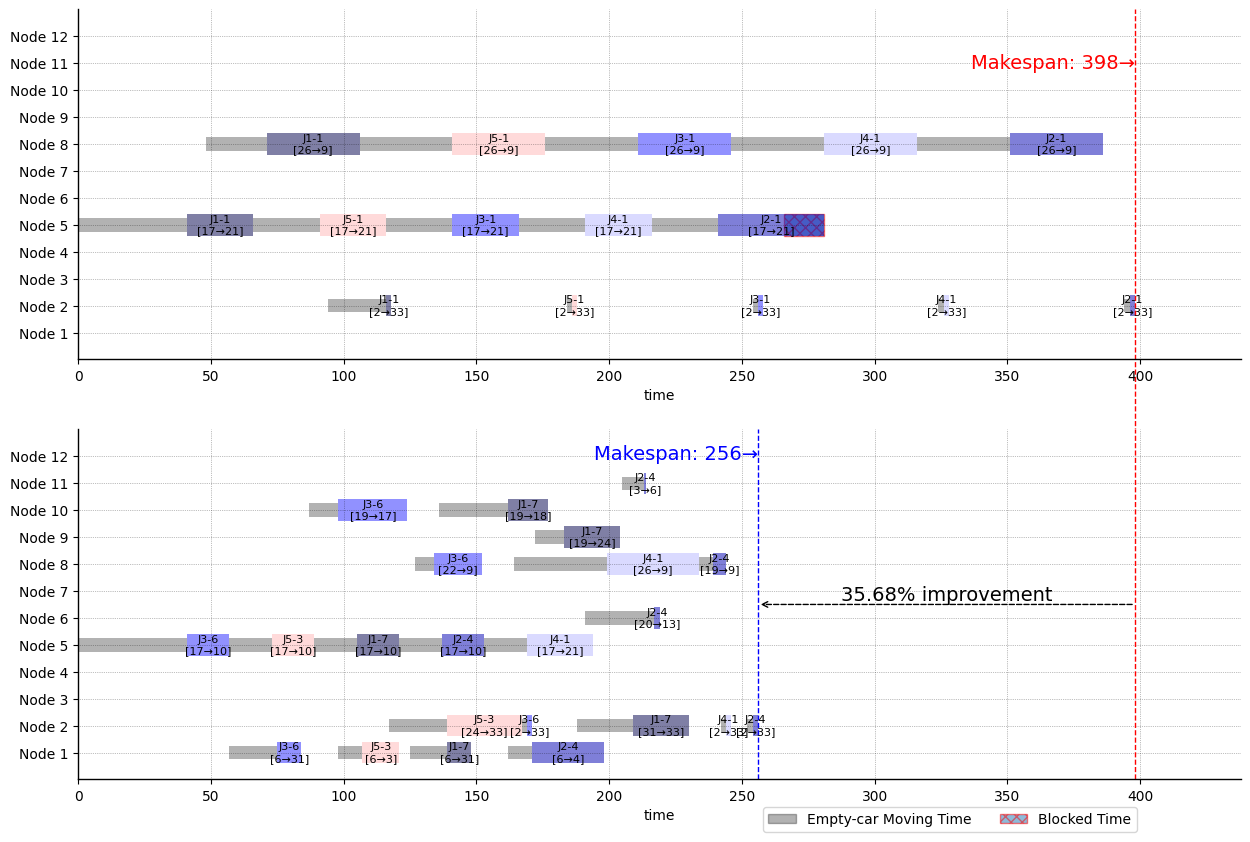

In [279]:
plt.rcParams['figure.figsize'] = [15, 10]
y_min = 10
fig, axes = plt.subplots(2,1)


for n in range(Benchmark.num_nodes):
    node_seq_name = f"Node {n} seq"
    intvs = fixed_msol.get_var_solution(node_seq_name).get_value()
    print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for intv in intvs:
        text = intv.get_name().split(" ")
        j = int(text[0][1:])
        opt = int(text[2])
        print(text)
        f = int(text[8])
        t = int(text[10][:-1])
        c = job_colors(j)
        v = intv.get_value()
        axes[0].barh(y=y_min+n*10, left=v.start, width=v.size, height=8, color=c, alpha=0.5)
        min_size = Benchmark.node_from_to[n][f][t]
        if v.size > min_size:
            extra = v.size - min_size
            axes[0].barh(y=y_min+n*10, left=v.end-extra, width=extra, height=8, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
        # veh_pos[n] += [f, t]
        # veh_pos_time[n] += [v.start, v.start+v.size]
        # job_pos[j] += [(n,f), (n,t)]
        # job_pos_time[j] += [v.start, v.start+v.size]
        
        text_coord_x = v.start + v.size/2
        axes[0].text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1}\n[{f+1}→{t+1}]", ha='center', va='center', fontsize=8)
        print(intv.get_name(), intv.get_value())
        
    for i in range(len(intvs)):
        if i == 0:
            second_intv = intvs[i].get_value()
            t = int(intvs[i].get_name().split(" ")[8])
            axes[0].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][0][t], width=Benchmark.node_from_to[n][0][t], height=5, color="k", alpha=0.3)
            # veh_pos[n] += [0]
            # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][0][t]]
        else:
            first_intv = intvs[i-1].get_value()
            second_intv = intvs[i].get_value()
            f = int(intvs[i-1].get_name().split(" ")[10][:-1])
            t = int(intvs[i].get_name().split(" ")[8])
            print(n, f, t, Benchmark.node_from_to[n][f][t])
            axes[0].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=5, color="k", alpha=0.3, label="Empty-car Moving Time")
            # veh_pos[n] += [f]
            # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][f][t]]

patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
patches += [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time")]

axes[0].set_ylim(0, 10*(Benchmark.num_nodes+1))
axes[0].set_xlim(0, fixed_msol.get_objective_value()*1.1)
axes[0].set_xlabel('time')
# es[0]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
axes[0].spines["bottom"].set_linewidth(1)
axes[0].spines["left"].set_linewidth(1)
axes[0].spines["top"].set_linewidth(0)
axes[0].spines["right"].set_linewidth(0)
axes[0].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes[0].set_yticks([y_min+10*n for n in range(Benchmark.num_nodes)])
axes[0].set_yticklabels([f"Node {i+1}" for i in range(Benchmark.num_nodes)])
axes[0].axvline(fixed_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed", clip_on=False, ymin=-1.2)
axes[0].text(fixed_msol.get_objective_value(), 10*(Benchmark.num_nodes-1), f"Makespan: {fixed_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')



for n in range(Benchmark.num_nodes):
    node_seq_name = f"Node {n} seq"
    intvs = flexible_msol.get_var_solution(node_seq_name).get_value()
    print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for intv in intvs:
        text = intv.get_name().split(" ")
        j = int(text[0][1:])
        opt = int(text[2])
        print(text)
        f = int(text[8])
        t = int(text[10][:-1])
        c = job_colors(j)
        v = intv.get_value()
        axes[1].barh(y=y_min+n*10, left=v.start, width=v.size, height=8, color=c, alpha=0.5)
        min_size = Benchmark.node_from_to[n][f][t]
        if v.size > min_size:
            extra = v.size - min_size
            axes[1].barh(y=y_min+n*10, left=v.end-extra, width=extra, height=8, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
        # veh_pos[n] += [f, t]
        # veh_pos_time[n] += [v.start, v.start+v.size]
        # job_pos[j] += [(n,f), (n,t)]
        # job_pos_time[j] += [v.start, v.start+v.size]
        
        text_coord_x = v.start + v.size/2
        axes[1].text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1}\n[{f+1}→{t+1}]", ha='center', va='center', fontsize=8)
        print(intv.get_name(), intv.get_value())
        
    for i in range(len(intvs)):
        if i == 0:
            second_intv = intvs[i].get_value()
            t = int(intvs[i].get_name().split(" ")[8])
            axes[1].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][0][t], width=Benchmark.node_from_to[n][0][t], height=5, color="k", alpha=0.3)
            # veh_pos[n] += [0]
            # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][0][t]]
        else:
            first_intv = intvs[i-1].get_value()
            second_intv = intvs[i].get_value()
            f = int(intvs[i-1].get_name().split(" ")[10][:-1])
            t = int(intvs[i].get_name().split(" ")[8])
            print(n, f, t, Benchmark.node_from_to[n][f][t])
            axes[1].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=5, color="k", alpha=0.3, label="Empty-car Moving Time")
            # veh_pos[n] += [f]
            # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][f][t]]

# patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
patches = [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time"), mpatches.Patch(label="Blocked Time", color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')]

axes[1].set_ylim(0, 10*(Benchmark.num_nodes+1))
axes[1].set_xlim(0, fixed_msol.get_objective_value()*1.1)
axes[1].set_xlabel('time')
# es[1]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
axes[1].spines["bottom"].set_linewidth(1)
axes[1].spines["left"].set_linewidth(1)
axes[1].spines["top"].set_linewidth(0)
axes[1].spines["right"].set_linewidth(0)
axes[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].set_yticks([y_min+10*n for n in range(Benchmark.num_nodes)])
axes[1].set_yticklabels([f"Node {i+1}" for i in range(Benchmark.num_nodes)])
axes[1].axvline(flexible_msol.get_objective_value(), color='b', linewidth=1, linestyle="dashed")
axes[1].axvline(fixed_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
# axes[1].text(fixed_msol.get_objective_value(), 10*(Benchmark.num_nodes-1), f"Makespan: {fixed_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')
axes[1].text(flexible_msol.get_objective_value(), 11*(Benchmark.num_nodes-1), f"Makespan: {flexible_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='b')
axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), (fixed_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), arrowprops={"arrowstyle":"->", "linestyle":"--","linewidth":1})
axes[1].text((flexible_msol.get_objective_value()+fixed_msol.get_objective_value())/2, 5*(Benchmark.num_nodes+1), f"{(fixed_msol.get_objective_value()-flexible_msol.get_objective_value())/fixed_msol.get_objective_value()*100:.2f}% improvement", ha='center', va='bottom', fontsize=14)
axes[1].legend(handles=patches, bbox_to_anchor=(0.75, -0.17), loc='lower center', ncols=2)

# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), (fixed_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), arrowprops={"arrowstyle":"<-", "linestyle":"--","linewidth":1})
# axes[0].legend(handles=patches)
# print(SAVE_FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
# print(SAVE_FOLDER)
# plt.savefig(f"Animation Gantt.png", bbox_inches='tight', dpi=300)
plt.savefig(f"{SAVE_FOLDER}/Gantt Chart of MHNSP Special Example (node).pdf", bbox_inches='tight')

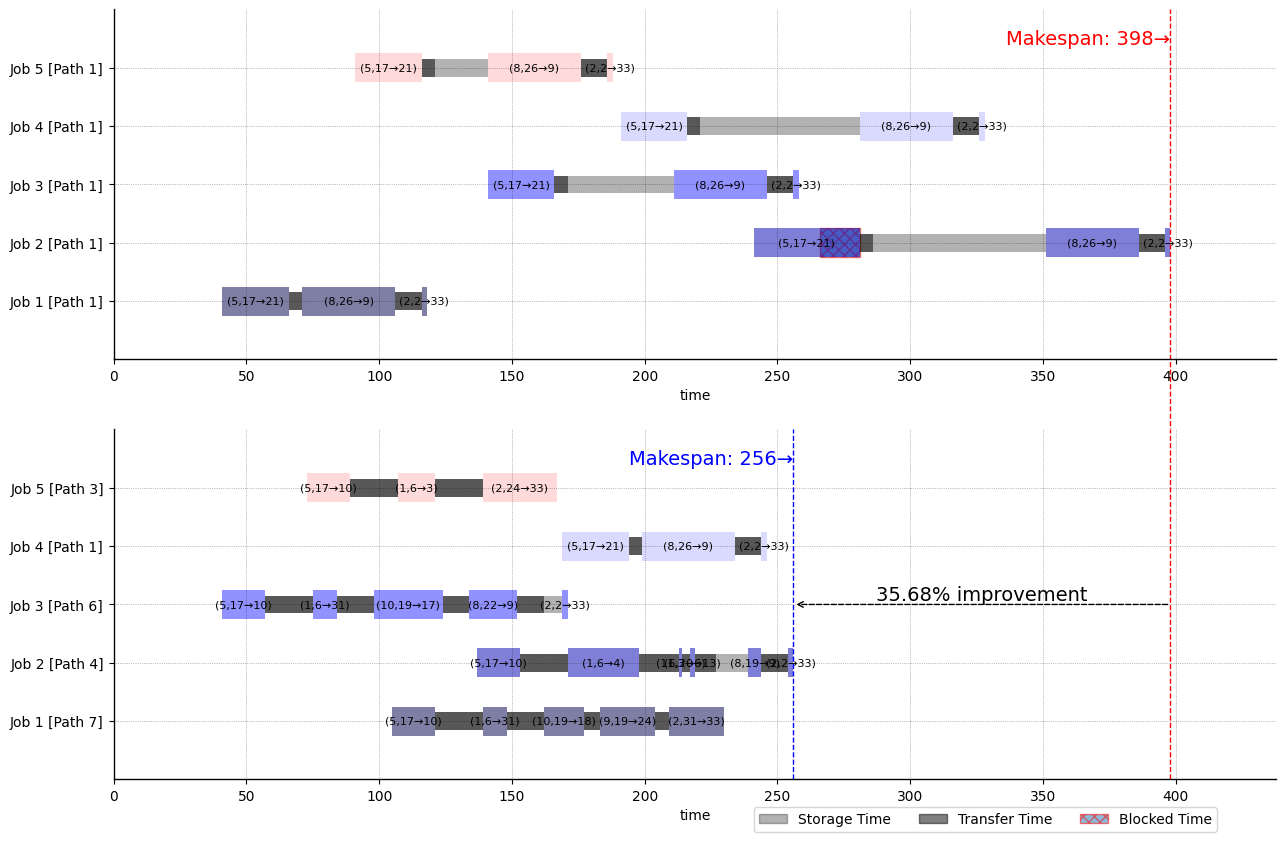

In [274]:
plt.rcParams['figure.figsize'] = [15, 10]
y_min = 10
fig, axes = plt.subplots(2,1)

num_jobs = 0
while True:
    if fixed_msol.get_var_solution(f"J{num_jobs} Overall") is not None:
        num_jobs += 1
    else:
        break 

path_selected = []
for job in range(num_jobs):
    intvs = []
    path_id = 0
    while len(intvs) == 0:
        if fixed_msol.get_var_solution(f"J{job} Option {path_id} Sequence") is not None:
            intvs = fixed_msol.get_var_solution(f"J{job} Option {path_id} Sequence").get_value()
            # break
        path_id += 1
    path_selected += [path_id]
    
    # node_seq_name = f"Node {n} seq"
    # intvs = fixed_msol.get_var_solution(node_seq_name).get_value()
    # print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for i, intv in enumerate(intvs):
        if i%2 == 0:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n = int(text[6])
            f = int(text[8])
            t = int(text[10][:-1])
            c = job_colors(j)
            v = intv.get_value()
            axes[0].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
            min_size = Benchmark.node_from_to[n][f][t]
            if v.size > min_size:
                extra = v.size - min_size
                axes[0].barh(y=y_min+j*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
            text_coord_x = v.start + v.size/2
            axes[0].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
            # text_coord_x = v.start + Benchmark.site_pt[(n1,p1,n2,p2)][0]/2
            # axes[0].text(text_coord_x, y_min+j*10, "$p^{("+f"{n+1}"+")}_{"+f"{f+1}"+"}$→$p^{()"+f"{n+1}"+")}_{"+f"{t+1}"+"}$", ha='center', va='center', fontsize=8)
        else:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n1 = int(text[6])
            p1 = int(text[7])
            n2 = int(text[9])
            p2 = int(text[10][:-1])
            # c = job_colors(j)
            v = intv.get_value()
            Benchmark.site_pt[(n1,p1,n2,p2)][0]
            axes[0].barh(y=y_min+j*10, left=v.start, width=v.size, height=3, color="k", alpha=0.3)
            axes[0].barh(y=y_min+j*10, left=v.start, width=Benchmark.site_pt[(n1,p1,n2,p2)][0], height=3, color="k", alpha=0.5)
            
            
#             pass
#         text = intv.get_name().split(" ")
#         j = int(text[0][1:])
#         opt = int(text[2])
#         print(text)
#         f = int(text[8])
#         t = int(text[10][:-1])
#         c = job_colors(j)
#         v = intv.get_value()
#         axes[0].barh(y=y_min+n*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
#         min_size = Benchmark.node_from_to[n][f][t]
#         if v.size > min_size:
#             extra = v.size - min_size
#             axes[0].barh(y=y_min+n*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
#         # veh_pos[n] += [f, t]
#         # veh_pos_time[n] += [v.start, v.start+v.size]
#         # job_pos[j] += [(n,f), (n,t)]
#         # job_pos_time[j] += [v.start, v.start+v.size]
        
#         text_coord_x = v.start + min_size/2
#         axes[0].text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1} [{f+1}→{t+1}]", ha='center', va='center', fontsize=8)
#         print(intv.get_name(), intv.get_value())
        
#     for i in range(len(intvs)):
#         if i == 0:
#             second_intv = intvs[i].get_value()
#             t = int(intvs[i].get_name().split(" ")[8])
#             axes[0].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][0][t], width=Benchmark.node_from_to[n][0][t], height=3, color="k", alpha=0.3)
#             # veh_pos[n] += [0]
#             # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][0][t]]
#         else:
#             first_intv = intvs[i-1].get_value()
#             second_intv = intvs[i].get_value()
#             f = int(intvs[i-1].get_name().split(" ")[10][:-1])
#             t = int(intvs[i].get_name().split(" ")[8])
#             print(n, f, t, Benchmark.node_from_to[n][f][t])
#             axes[0].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=3, color="k", alpha=0.3, label="Empty-car Moving Time")
#             # veh_pos[n] += [f]
#             # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][f][t]]

# patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
# patches += [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time")]

axes[0].set_ylim(0, 10*(num_jobs+1))
axes[0].set_xlim(0, fixed_msol.get_objective_value()*1.1)
axes[0].set_xlabel('time')
# es[0]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
axes[0].spines["bottom"].set_linewidth(1)
axes[0].spines["left"].set_linewidth(1)
axes[0].spines["top"].set_linewidth(0)
axes[0].spines["right"].set_linewidth(0)
axes[0].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes[0].set_yticks([y_min+10*n for n in range(num_jobs)])
axes[0].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
axes[0].axvline(fixed_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed",clip_on=False,ymin=-1.2)
axes[0].text(fixed_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')


path_selected = []
for job in range(num_jobs):
    intvs = []
    path_id = 0
    while len(intvs) == 0:
        if flexible_msol.get_var_solution(f"J{job} Option {path_id} Sequence") is not None:
            intvs = flexible_msol.get_var_solution(f"J{job} Option {path_id} Sequence").get_value()
            # break
        path_id += 1
    path_selected += [path_id]
    
    # node_seq_name = f"Node {n} seq"
    # intvs = fixed_msol.get_var_solution(node_seq_name).get_value()
    # print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for i, intv in enumerate(intvs):
        if i%2 == 0:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n = int(text[6])
            f = int(text[8])
            t = int(text[10][:-1])
            c = job_colors(j)
            v = intv.get_value()
            axes[1].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
            min_size = Benchmark.node_from_to[n][f][t]
            if v.size > min_size:
                extra = v.size - min_size
                axes[1].barh(y=y_min+j*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
            text_coord_x = v.start + v.size/2
            axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
            
            # axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
        else:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n1 = int(text[6])
            p1 = int(text[7])
            n2 = int(text[9])
            p2 = int(text[10][:-1])
            # c = job_colors(j)
            v = intv.get_value()
            Benchmark.site_pt[(n1,p1,n2,p2)][0]
            axes[1].barh(y=y_min+j*10, left=v.start, width=v.size, height=3, color="k", alpha=0.3)
            axes[1].barh(y=y_min+j*10, left=v.start, width=Benchmark.site_pt[(n1,p1,n2,p2)][0], height=3, color="k", alpha=0.5)

# patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
# patches += [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time")]
patches = [mpatches.Patch(color="k", alpha=0.3, label="Storage Time"), mpatches.Patch(color="k", alpha=0.5, label="Transfer Time"),mpatches.Patch(label="Blocked Time", color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')]

axes[1].set_ylim(0, 10*(num_jobs+1))
axes[1].set_xlim(0, fixed_msol.get_objective_value()*1.1)
axes[1].set_xlabel('time')
# es[1]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
axes[1].spines["bottom"].set_linewidth(1)
axes[1].spines["left"].set_linewidth(1)
axes[1].spines["top"].set_linewidth(0)
axes[1].spines["right"].set_linewidth(0)
axes[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].set_yticks([y_min+10*n for n in range(num_jobs)])
axes[1].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
axes[1].axvline(flexible_msol.get_objective_value(), color='b', linewidth=1, linestyle="dashed")
axes[1].axvline(fixed_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
# axes[1].text(fixed_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')
axes[1].text(flexible_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {flexible_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='b')
axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(num_jobs+1)), (fixed_msol.get_objective_value(), 5*(num_jobs+1)), arrowprops={"arrowstyle":"->", "linestyle":"--","linewidth":1})
axes[1].text((flexible_msol.get_objective_value()+fixed_msol.get_objective_value())/2, 5*(num_jobs+1), f"{(fixed_msol.get_objective_value()-flexible_msol.get_objective_value())/fixed_msol.get_objective_value()*100:.2f}% improvement", ha='center', va='bottom', fontsize=14)
# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), (fixed_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), arrowprops={"arrowstyle":"<-", "linestyle":"--","linewidth":1})
axes[1].legend(handles=patches, bbox_to_anchor=(0.75, -0.17), loc='lower center', ncols=3)
# print(SAVE_FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
# print(SAVE_FOLDER)
# plt.savefig(f"Animation Gantt.png", bbox_inches='tight', dpi=300)
# plt.savefig(f"{SAVE_FOLDER}/Gantt Chart of MHSP Example (Sol D).pdf", bbox_inches='tight')
plt.savefig(f"{SAVE_FOLDER}/Gantt Chart of MHNSP Special Example (job).pdf", bbox_inches='tight')


In [226]:
FOLDER = "Thesis Benchmark (Reachability not Guaranteed) Results (Special Case)"
FOLDER_net = "Thesis Benchmark (Reachability not Guaranteed)"
# Benchmark = MHSP_Benchmark(data, max_num_jobs = 5)
# FOLDER = "Thesis Benchmark Results"
for networks, NETWORK in get_next_network(FOLDER):
    data,_,_ = get_benchmark(FOLDER_net, networks, NETWORK)
    Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    # fixed_msol = get_CP_result(path, fixed=True, inf=False)
    # flexible_msol = get_CP_result(path, fixed=False, inf=False)
    fixed_random_msol = get_CP_result(path, fixed=True, inf=False, random_one=True, id=4)

['Network N12S48PD50C3']
Thesis Benchmark (Reachability not Guaranteed)/Network N12S48PD50C3/network-1/Flexible J8.json


100%|██████████| 8/8 [00:00<00:00, 306.49it/s]

2024-06-02 14:44:22 fixed random one finite-4


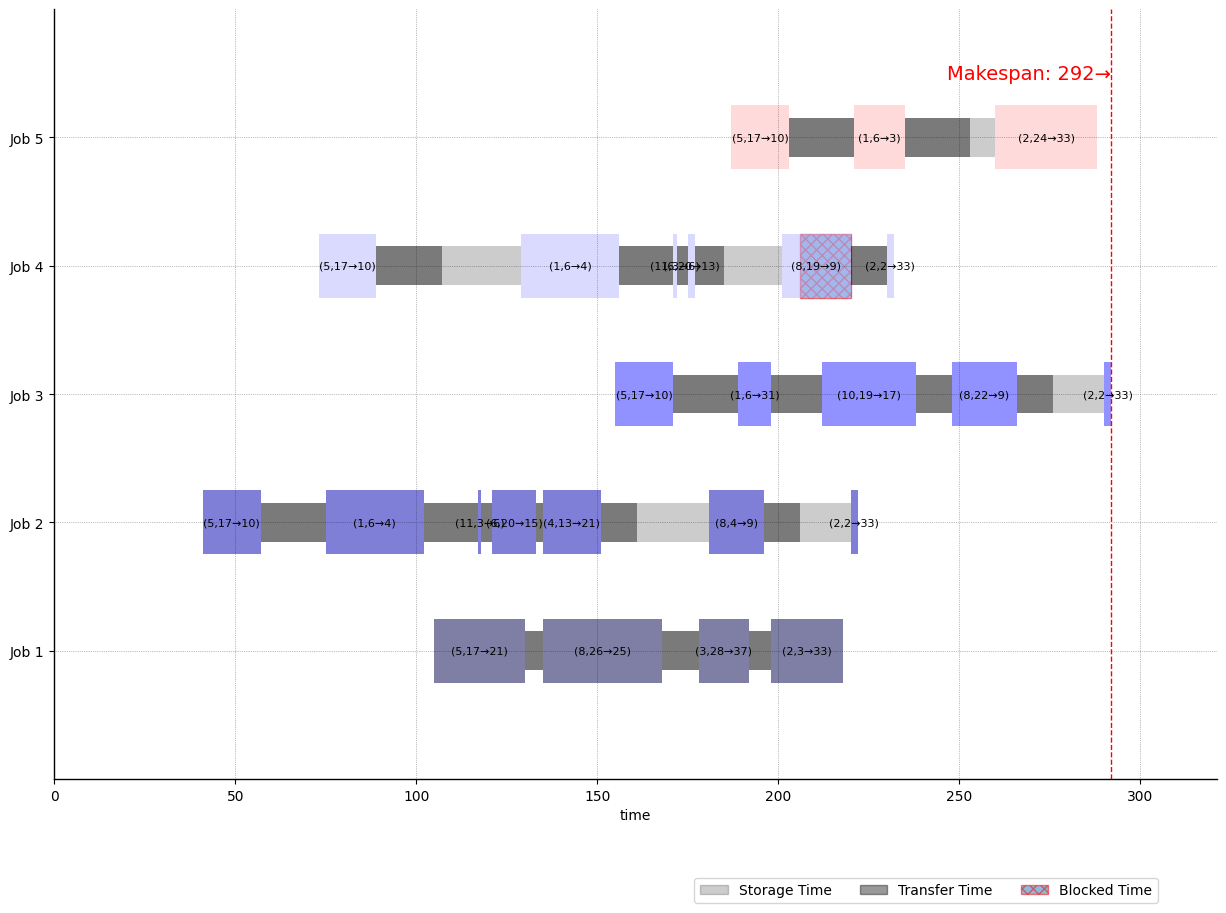

In [251]:
plt.rcParams['figure.figsize'] = [15, 10]
y_min = 10
fig, axes = plt.subplots(1,1)

num_jobs = 0
while True:
    if fixed_random_msol.get_var_solution(f"J{num_jobs} Overall") is not None:
        num_jobs += 1
    else:
        break 

path_selected = []
for job in range(num_jobs):
    intvs = []
    path_id = 0
    while len(intvs) == 0:
        if fixed_random_msol.get_var_solution(f"J{job} Option {path_id} Sequence") is not None:
            intvs = fixed_random_msol.get_var_solution(f"J{job} Option {path_id} Sequence").get_value()
            # break
        path_id += 1
    path_selected += [path_id]
    
    # node_seq_name = f"Node {n} seq"
    # intvs = fixed_msol.get_var_solution(node_seq_name).get_value()
    # print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for i, intv in enumerate(intvs):
        if i%2 == 0:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n = int(text[6])
            f = int(text[8])
            t = int(text[10][:-1])
            c = job_colors(j)
            v = intv.get_value()
            axes.barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
            min_size = Benchmark.node_from_to[n][f][t]
            if v.size > min_size:
                extra = v.size - min_size
                axes.barh(y=y_min+j*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
            text_coord_x = v.start + v.size/2
            axes.text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
            # text_coord_x = v.start + Benchmark.site_pt[(n1,p1,n2,p2)][0]/2
            # axes[0].text(text_coord_x, y_min+j*10, "$p^{("+f"{n+1}"+")}_{"+f"{f+1}"+"}$→$p^{()"+f"{n+1}"+")}_{"+f"{t+1}"+"}$", ha='center', va='center', fontsize=8)
        else:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n1 = int(text[6])
            p1 = int(text[7])
            n2 = int(text[9])
            p2 = int(text[10][:-1])
            # c = job_colors(j)
            v = intv.get_value()
            Benchmark.site_pt[(n1,p1,n2,p2)][0]
            axes.barh(y=y_min+j*10, left=v.start, width=v.size, height=3, color="k", alpha=0.2)
            axes.barh(y=y_min+j*10, left=v.start, width=Benchmark.site_pt[(n1,p1,n2,p2)][0], height=3, color="k", alpha=0.4)
            
            
#             pass
#         text = intv.get_name().split(" ")
#         j = int(text[0][1:])
#         opt = int(text[2])
#         print(text)
#         f = int(text[8])
#         t = int(text[10][:-1])
#         c = job_colors(j)
#         v = intv.get_value()
#         axes[0].barh(y=y_min+n*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
#         min_size = Benchmark.node_from_to[n][f][t]
#         if v.size > min_size:
#             extra = v.size - min_size
#             axes[0].barh(y=y_min+n*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
#         # veh_pos[n] += [f, t]
#         # veh_pos_time[n] += [v.start, v.start+v.size]
#         # job_pos[j] += [(n,f), (n,t)]
#         # job_pos_time[j] += [v.start, v.start+v.size]
        
#         text_coord_x = v.start + min_size/2
#         axes[0].text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1} [{f+1}→{t+1}]", ha='center', va='center', fontsize=8)
#         print(intv.get_name(), intv.get_value())
        
#     for i in range(len(intvs)):
#         if i == 0:
#             second_intv = intvs[i].get_value()
#             t = int(intvs[i].get_name().split(" ")[8])
#             axes[0].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][0][t], width=Benchmark.node_from_to[n][0][t], height=3, color="k", alpha=0.3)
#             # veh_pos[n] += [0]
#             # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][0][t]]
#         else:
#             first_intv = intvs[i-1].get_value()
#             second_intv = intvs[i].get_value()
#             f = int(intvs[i-1].get_name().split(" ")[10][:-1])
#             t = int(intvs[i].get_name().split(" ")[8])
#             print(n, f, t, Benchmark.node_from_to[n][f][t])
#             axes[0].barh(y=y_min+n*10, left=second_intv.start-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=3, color="k", alpha=0.3, label="Empty-car Moving Time")
#             # veh_pos[n] += [f]
#             # veh_pos_time[n] += [second_intv.start-node_from_to[NODE.id][f][t]]

# patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
# patches += [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time")]

axes.set_ylim(0, 10*(num_jobs+1))
axes.set_xlim(0, fixed_random_msol.get_objective_value()*1.1)
axes.set_xlabel('time')
# esax.set_title("Gantt Chart of MHNSP Example (Solution D)")
axes.spines["bottom"].set_linewidth(1)
axes.spines["left"].set_linewidth(1)
axes.spines["top"].set_linewidth(0)
axes.spines["right"].set_linewidth(0)
axes.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes.set_yticks([y_min+10*n for n in range(num_jobs)])
axes.set_yticklabels([f"Job {i+1}" for i in range(num_jobs)])
# axes.set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
axes.axvline(fixed_random_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
axes.text(fixed_random_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_random_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')


# path_selected = []
# for job in range(num_jobs):
#     intvs = []
#     path_id = 0
#     while len(intvs) == 0:
#         if flexible_msol.get_var_solution(f"J{job} Option {path_id} Sequence") is not None:
#             intvs = flexible_msol.get_var_solution(f"J{job} Option {path_id} Sequence").get_value()
#             # break
#         path_id += 1
#     path_selected += [path_id]
    
#     # node_seq_name = f"Node {n} seq"
#     # intvs = fixed_msol.get_var_solution(node_seq_name).get_value()
#     # print(intvs)
#     # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
#     for i, intv in enumerate(intvs):
#         if i%2 == 0:
#             text = intv.get_name().split(" ")
#             j = int(text[0][1:])
#             opt = int(text[2])
#             # print(text)
#             n = int(text[6])
#             f = int(text[8])
#             t = int(text[10][:-1])
#             c = job_colors(j)
#             v = intv.get_value()
#             axes[1].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
#             min_size = Benchmark.node_from_to[n][f][t]
#             if v.size > min_size:
#                 extra = v.size - min_size
#                 axes[1].barh(y=y_min+j*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
#             text_coord_x = v.start + min_size/2
#             axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
            
#             # axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
#         else:
#             text = intv.get_name().split(" ")
#             j = int(text[0][1:])
#             opt = int(text[2])
#             # print(text)
#             n1 = int(text[6])
#             p1 = int(text[7])
#             n2 = int(text[9])
#             p2 = int(text[10][:-1])
#             # c = job_colors(j)
#             v = intv.get_value()
#             Benchmark.site_pt[(n1,p1,n2,p2)][0]
#             axes[1].barh(y=y_min+j*10, left=v.start, width=v.size, height=3, color="k", alpha=0.3)
#             axes[1].barh(y=y_min+j*10, left=v.start, width=Benchmark.site_pt[(n1,p1,n2,p2)][0], height=3, color="k", alpha=0.5)

# # patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
# # patches += [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time")]
patches = [mpatches.Patch(color="k", alpha=0.2, label="Storage Time"), mpatches.Patch(color="k", alpha=0.4, label="Transfer Time"),mpatches.Patch(label="Blocked Time", color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')]

# axes[1].set_ylim(0, 10*(num_jobs+1))
# axes[1].set_xlim(0, fixed_msol.get_objective_value()*1.1)
# axes[1].set_xlabel('time')
# # es[1]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
# axes[1].spines["bottom"].set_linewidth(1)
# axes[1].spines["left"].set_linewidth(1)
# axes[1].spines["top"].set_linewidth(0)
# axes[1].spines["right"].set_linewidth(0)
# axes[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
# axes[1].set_yticks([y_min+10*n for n in range(num_jobs)])
# axes[1].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
# axes[1].axvline(flexible_msol.get_objective_value(), color='b', linewidth=1, linestyle="dashed")
# axes[1].axvline(fixed_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
# axes[1].text(fixed_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')
# axes[1].text(flexible_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {flexible_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='b')
# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(num_jobs+1)), (fixed_msol.get_objective_value(), 5*(num_jobs+1)), arrowprops={"arrowstyle":"->", "linestyle":"--","linewidth":1})
# axes[1].text((flexible_msol.get_objective_value()+fixed_msol.get_objective_value())/2, 5*(num_jobs+1), f"{(fixed_msol.get_objective_value()-flexible_msol.get_objective_value())/fixed_msol.get_objective_value()*100:.2f}% improvement", ha='center', va='bottom', fontsize=14)
# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), (fixed_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), arrowprops={"arrowstyle":"<-", "linestyle":"--","linewidth":1})
axes.legend(handles=patches, bbox_to_anchor=(0.75, -0.17), loc='lower center', ncols=3)
# print(SAVE_FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
# print(SAVE_FOLDER)
# plt.savefig(f"Animation Gantt.png", bbox_inches='tight', dpi=300)
# plt.savefig(f"{SAVE_FOLDER}/Gantt Chart of MHSP Example (Sol D).pdf", bbox_inches='tight')
# plt.savefig(f"{SAVE_FOLDER}/Gantt Chart of MHNSP Special Example (job).pdf", bbox_inches='tight')


J0 Overall: (start=105, end=218, size=113, length=113)
J1 Overall: (start=41, end=222, size=181, length=181)
J2 Overall: (start=155, end=292, size=137, length=137)
J3 Overall: (start=73, end=232, size=159, length=159)
J4 Overall: (start=187, end=288, size=101, length=101)
J4 Overall: (start=187, end=288, size=101, length=101)
J0 Overall: (start=105, end=218, size=113, length=113)
J1 Overall: (start=41, end=222, size=181, length=181)
J2 Overall: (start=155, end=292, size=137, length=137)
J3 Overall: (start=73, end=232, size=159, length=159)


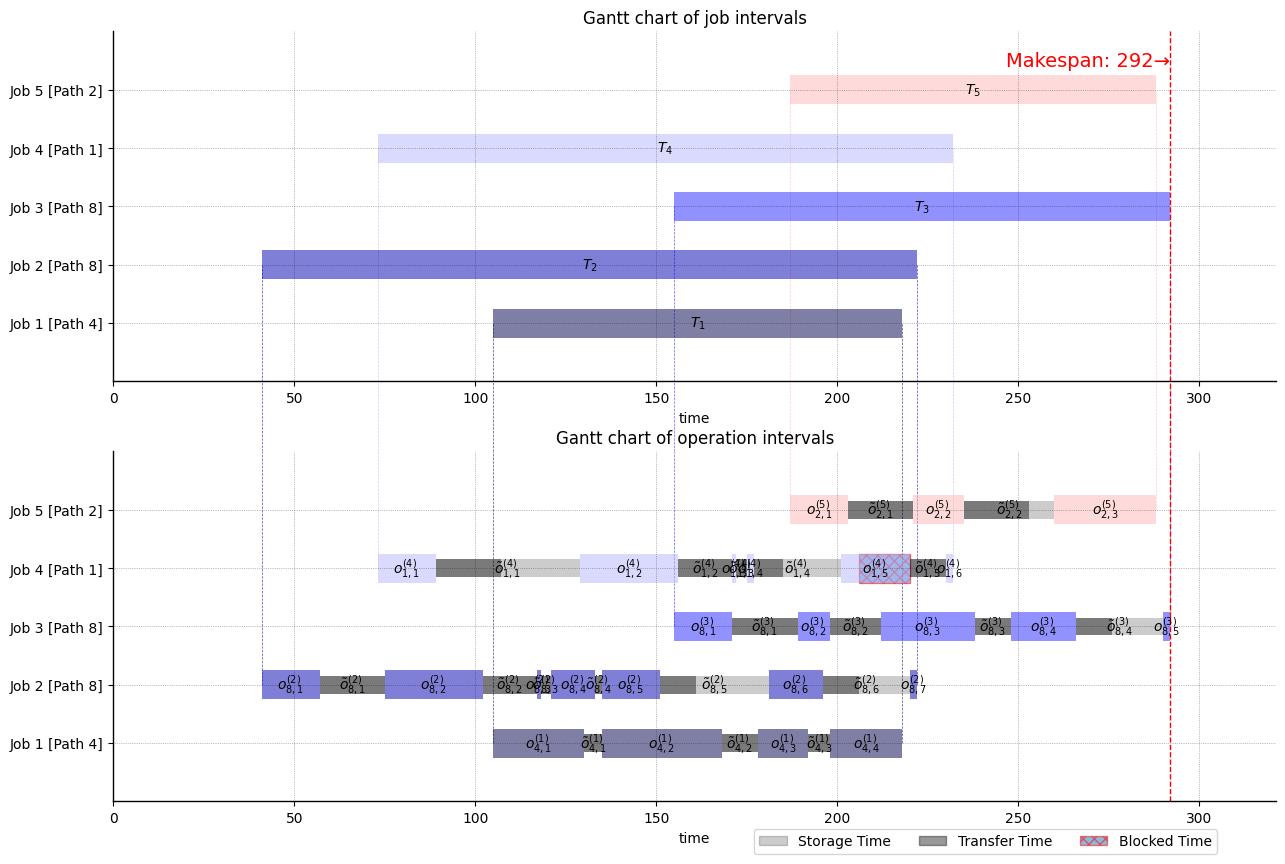

In [277]:
plt.rcParams['figure.figsize'] = [15, 10]
y_min = 10
fig, axes = plt.subplots(2,1)

num_jobs = 0
while True:
    if fixed_random_msol.get_var_solution(f"J{num_jobs} Overall") is not None:
        num_jobs += 1
    else:
        break 

np.random.seed(1000)
path_selected = np.random.randint(1, 10, num_jobs)
for j in range(num_jobs):
    intv = fixed_random_msol.get_var_solution(f"J{j} Overall")
    print(intv)
    # continue
    c = job_colors(j)
    v = intv.get_value()
    axes[0].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
    text_coord_x = v.start + v.size/2
    axes[0].text(text_coord_x, y_min+j*10, f"$T_{j+1}$", ha='center', va='center', fontsize=10)
    axes[0].axvline(x=v.start,ymin=-1.2,ymax=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")
    axes[0].axvline(x=v.end,ymin=-1.2,ymax=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")

axes[0].set_ylim(0, 10*(num_jobs+1))
axes[0].set_xlim(0, fixed_random_msol.get_objective_value()*1.1)
axes[0].set_xlabel('time')
axes[0].set_title("Gantt chart of job intervals")
axes[0].spines["bottom"].set_linewidth(1)
axes[0].spines["left"].set_linewidth(1)
axes[0].spines["top"].set_linewidth(0)
axes[0].spines["right"].set_linewidth(0)
axes[0].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes[0].set_yticks([y_min+10*n for n in range(num_jobs)])
axes[0].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
# ax[0]es.set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
axes[0].axvline(fixed_random_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed", clip_on=False, ymin=-1.2)
axes[0].text(fixed_random_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_random_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')


# path_selected = []
for job in range(num_jobs):
    intvs = []
    path_id = 0
    while len(intvs) == 0:
        if fixed_random_msol.get_var_solution(f"J{job} Option {path_id} Sequence") is not None:
            intvs = fixed_random_msol.get_var_solution(f"J{job} Option {path_id} Sequence").get_value()
            # break
        path_id += 1
    intv = fixed_random_msol.get_var_solution(f"J{j} Overall")
    print(intv)
    # continue
    c = job_colors(j)
    v = intv.get_value()
    # axes[0].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
    # text_coord_x = v.start + v.size/2
    # axes[0].text(text_coord_x, y_min+j*10, f"$T_{j+1}$", ha='center', va='center', fontsize=8)
    axes[1].axvline(x=v.start,ymax=1,ymin=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")
    axes[1].axvline(x=v.end,ymax=1,ymin=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")
    # path_selected += [path_id]
    
    # node_seq_name = f"Node {n} seq"
    # intvs = fixed_msol.get_var_solution(node_seq_name).get_value()
    # print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for i, intv in enumerate(intvs):
        if i%2 == 0:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n = int(text[6])
            f = int(text[8])
            t = int(text[10][:-1])
            c = job_colors(j)
            v = intv.get_value()
            axes[1].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
            min_size = Benchmark.node_from_to[n][f][t]
            if v.size > min_size:
                extra = v.size - min_size
                axes[1].barh(y=y_min+j*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
            text_coord_x = v.start + v.size/2
            axes[1].text(text_coord_x, y_min+j*10, "$o^{("+f"{j+1}"+")}_{"+f"{path_selected[j]},{i//2+1}"+"}$", ha='center', va='center', fontsize=10)
            # axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
            
            # axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
        else:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n1 = int(text[6])
            p1 = int(text[7])
            n2 = int(text[9])
            p2 = int(text[10][:-1])
            # c = job_colors(j)
            v = intv.get_value()
            Benchmark.site_pt[(n1,p1,n2,p2)][0]
            axes[1].barh(y=y_min+j*10, left=v.start, width=v.size, height=3, color="k", alpha=0.2)
            axes[1].barh(y=y_min+j*10, left=v.start, width=Benchmark.site_pt[(n1,p1,n2,p2)][0], height=3, color="k", alpha=0.4)
            text_coord_x = v.start + v.size/2
            axes[1].text(text_coord_x, y_min+j*10, "$\\tilde{o}^{("+f"{j+1}"+")}_{"+f"{path_selected[j]},{i//2+1}"+"}$", ha='center', va='center', fontsize=10)
            

# # patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
# # patches += [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time")]
patches = [mpatches.Patch(color="k", alpha=0.2, label="Storage Time"), mpatches.Patch(color="k", alpha=0.4, label="Transfer Time"),mpatches.Patch(label="Blocked Time", color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')]

axes[1].set_ylim(0, 10*(num_jobs+1))
axes[1].set_xlim(0, fixed_random_msol.get_objective_value()*1.1)
axes[1].set_xlabel('time')
axes[1].set_title("Gantt chart of operation intervals")
# es[1]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
axes[1].spines["bottom"].set_linewidth(1)
axes[1].spines["left"].set_linewidth(1)
axes[1].spines["top"].set_linewidth(0)
axes[1].spines["right"].set_linewidth(0)
axes[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes[1].set_yticks([y_min+10*n for n in range(num_jobs)])
axes[1].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
# ax[1]es.set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
axes[1].axvline(fixed_random_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
# axes[1].text(fixed_random_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_random_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')

# axes[1].set_ylim(0, 10*(num_jobs+1))
# axes[1].set_xlim(0, fixed_msol.get_objective_value()*1.1)
# axes[1].set_xlabel('time')
# # es[1]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
# axes[1].spines["bottom"].set_linewidth(1)
# axes[1].spines["left"].set_linewidth(1)
# axes[1].spines["top"].set_linewidth(0)
# axes[1].spines["right"].set_linewidth(0)
# axes[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
# axes[1].set_yticks([y_min+10*n for n in range(num_jobs)])
# axes[1].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
# axes[1].axvline(flexible_msol.get_objective_value(), color='b', linewidth=1, linestyle="dashed")
# axes[1].axvline(fixed_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
# axes[1].text(fixed_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')
# axes[1].text(flexible_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {flexible_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='b')
# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(num_jobs+1)), (fixed_msol.get_objective_value(), 5*(num_jobs+1)), arrowprops={"arrowstyle":"->", "linestyle":"--","linewidth":1})
# axes[1].text((flexible_msol.get_objective_value()+fixed_msol.get_objective_value())/2, 5*(num_jobs+1), f"{(fixed_msol.get_objective_value()-flexible_msol.get_objective_value())/fixed_msol.get_objective_value()*100:.2f}% improvement", ha='center', va='bottom', fontsize=14)
# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), (fixed_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), arrowprops={"arrowstyle":"<-", "linestyle":"--","linewidth":1})
axes[1].legend(handles=patches, bbox_to_anchor=(0.75, -0.17), loc='lower center', ncols=3)
# print(SAVE_FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
# print(SAVE_FOLDER)
# plt.savefig(f"Animation Gantt.png", bbox_inches='tight', dpi=300)
# plt.savefig(f"{SAVE_FOLDER}/Gantt Chart of MHSP Example (Sol D).pdf", bbox_inches='tight')
plt.savefig(f"{SAVE_FOLDER}/Gantt Chart Example (CP).pdf", bbox_inches='tight')


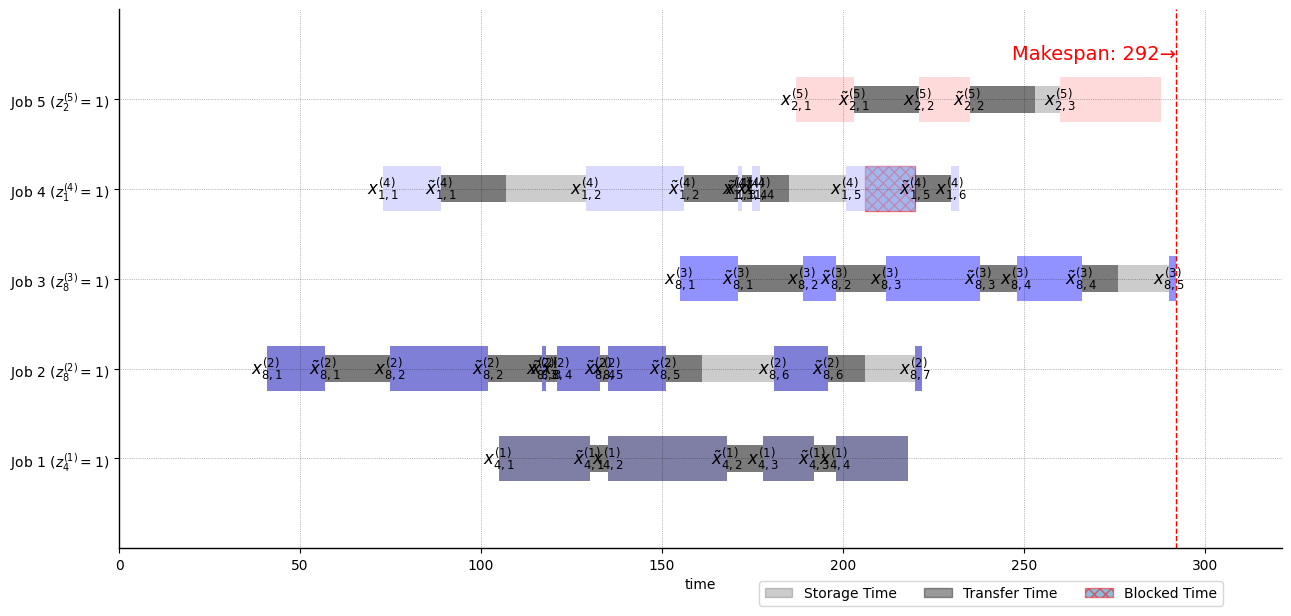

In [278]:
plt.rcParams['figure.figsize'] = [15, 7]
y_min = 10
fig, axes = plt.subplots(1,1)

num_jobs = 0
while True:
    if fixed_random_msol.get_var_solution(f"J{num_jobs} Overall") is not None:
        num_jobs += 1
    else:
        break 

np.random.seed(1000)
path_selected = np.random.randint(1, 10, num_jobs)
# for j in range(num_jobs):
#     intv = fixed_random_msol.get_var_solution(f"J{j} Overall")
#     print(intv)
#     # continue
#     c = job_colors(j)
#     v = intv.get_value()
#     axes[0].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
#     text_coord_x = v.start + v.size/2
#     axes[0].text(text_coord_x, y_min+j*10, f"$T_{j+1}$", ha='center', va='center', fontsize=8)
#     axes[0].axvline(x=v.start,ymin=-1.2,ymax=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")
#     axes[0].axvline(x=v.end,ymin=-1.2,ymax=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")

# axes[0].set_ylim(0, 10*(num_jobs+1))
# axes[0].set_xlim(0, fixed_random_msol.get_objective_value()*1.1)
# axes[0].set_xlabel('time')
# axes[0].set_title("Gantt chart of job intervals")
# axes[0].spines["bottom"].set_linewidth(1)
# axes[0].spines["left"].set_linewidth(1)
# axes[0].spines["top"].set_linewidth(0)
# axes[0].spines["right"].set_linewidth(0)
# axes[0].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
# axes[0].set_yticks([y_min+10*n for n in range(num_jobs)])
# axes[0].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
# # ax[0]es.set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
# axes[0].axvline(fixed_random_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
# axes[0].text(fixed_random_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_random_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')


# path_selected = []
for job in range(num_jobs):
    intvs = []
    path_id = 0
    while len(intvs) == 0:
        if fixed_random_msol.get_var_solution(f"J{job} Option {path_id} Sequence") is not None:
            intvs = fixed_random_msol.get_var_solution(f"J{job} Option {path_id} Sequence").get_value()
            # break
        path_id += 1
    # intv = fixed_random_msol.get_var_solution(f"J{j} Overall")
    # print(intv)
    # continue
    # c = job_colors(j)
    # v = intv.get_value()
    # axes[0].barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
    # text_coord_x = v.start + v.size/2
    # axes[0].text(text_coord_x, y_min+j*10, f"$T_{j+1}$", ha='center', va='center', fontsize=8)
    # axes.axvline(x=v.start,ymax=1,ymin=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")
    # axes[1].axvline(x=v.end,ymax=1,ymin=(j+1)/6,c=c,linewidth=0.5,zorder=0, clip_on=False, alpha=0.7, linestyle="dashed")
    # path_selected += [path_id]
    
    # node_seq_name = f"Node {n} seq"
    # intvs = fixed_msol.get_var_solution(node_seq_name).get_value()
    # print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for i, intv in enumerate(intvs):
        if i%2 == 0:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n = int(text[6])
            f = int(text[8])
            t = int(text[10][:-1])
            c = job_colors(j)
            v = intv.get_value()
            axes.barh(y=y_min+j*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
            min_size = Benchmark.node_from_to[n][f][t]
            if v.size > min_size:
                extra = v.size - min_size
                axes.barh(y=y_min+j*10, left=v.end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
            text_coord_x = v.start
            axes.text(text_coord_x, y_min+j*10, "$x^{("+f"{j+1}"+")}_{"+f"{path_selected[j]},{i//2+1}"+"}$", ha='center', va='center', fontsize=12)
            # axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
            
            # axes[1].text(text_coord_x, y_min+j*10, f"({n+1},{f+1}→{t+1})", ha='center', va='center', fontsize=8)
        else:
            text = intv.get_name().split(" ")
            j = int(text[0][1:])
            opt = int(text[2])
            # print(text)
            n1 = int(text[6])
            p1 = int(text[7])
            n2 = int(text[9])
            p2 = int(text[10][:-1])
            # c = job_colors(j)
            v = intv.get_value()
            Benchmark.site_pt[(n1,p1,n2,p2)][0]
            axes.barh(y=y_min+j*10, left=v.start, width=v.size, height=3, color="k", alpha=0.2)
            axes.barh(y=y_min+j*10, left=v.start, width=Benchmark.site_pt[(n1,p1,n2,p2)][0], height=3, color="k", alpha=0.4)
            text_coord_x = v.start
            axes.text(text_coord_x, y_min+j*10, "$\\tilde{x}^{("+f"{j+1}"+")}_{"+f"{path_selected[j]},{i//2+1}"+"}$", ha='center', va='center', fontsize=12)
            

# # patches = [mpatches.Patch(color=job_colors(c), alpha=0.5, label=f'Delivery Operation of Job {c+1}') for c in range(Benchmark.num_jobs)]
# # patches += [mpatches.Patch(color="k", alpha=0.3, label="Empty-car Moving Time")]
patches = [mpatches.Patch(color="k", alpha=0.2, label="Storage Time"), mpatches.Patch(color="k", alpha=0.4, label="Transfer Time"),mpatches.Patch(label="Blocked Time", color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')]

axes.set_ylim(0, 10*(num_jobs+1))
axes.set_xlim(0, fixed_random_msol.get_objective_value()*1.1)
axes.set_xlabel('time')
# axes.set_title("Gantt chart of operation intervals")
# esax.set_title("Gantt Chart of MHNSP Example (Solution D)")
axes.spines["bottom"].set_linewidth(1)
axes.spines["left"].set_linewidth(1)
axes.spines["top"].set_linewidth(0)
axes.spines["right"].set_linewidth(0)
axes.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
axes.set_yticks([y_min+10*n for n in range(num_jobs)])
axes.set_yticklabels([f"Job {i+1} ($z^{{({i+1})}}_{path_selected[i]}=1$)" for i in range(num_jobs)])
# axes.set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
axes.axvline(fixed_random_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
axes.text(fixed_random_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_random_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')

# axes[1].set_ylim(0, 10*(num_jobs+1))
# axes[1].set_xlim(0, fixed_msol.get_objective_value()*1.1)
# axes[1].set_xlabel('time')
# # es[1]ax.set_title("Gantt Chart of MHNSP Example (Solution D)")
# axes[1].spines["bottom"].set_linewidth(1)
# axes[1].spines["left"].set_linewidth(1)
# axes[1].spines["top"].set_linewidth(0)
# axes[1].spines["right"].set_linewidth(0)
# axes[1].grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
# axes[1].set_yticks([y_min+10*n for n in range(num_jobs)])
# axes[1].set_yticklabels([f"Job {i+1} [Path {path_selected[i]}]" for i in range(num_jobs)])
# axes[1].axvline(flexible_msol.get_objective_value(), color='b', linewidth=1, linestyle="dashed")
# axes[1].axvline(fixed_msol.get_objective_value(), color='r', linewidth=1, linestyle="dashed")
# axes[1].text(fixed_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {fixed_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='r')
# axes[1].text(flexible_msol.get_objective_value(), 10*num_jobs+5, f"Makespan: {flexible_msol.get_objective_value()}→", ha='right', va='center', fontsize=14, color='b')
# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(num_jobs+1)), (fixed_msol.get_objective_value(), 5*(num_jobs+1)), arrowprops={"arrowstyle":"->", "linestyle":"--","linewidth":1})
# axes[1].text((flexible_msol.get_objective_value()+fixed_msol.get_objective_value())/2, 5*(num_jobs+1), f"{(fixed_msol.get_objective_value()-flexible_msol.get_objective_value())/fixed_msol.get_objective_value()*100:.2f}% improvement", ha='center', va='bottom', fontsize=14)
# axes[1].annotate("", (flexible_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), (fixed_msol.get_objective_value(), 5*(Benchmark.num_nodes+1)), arrowprops={"arrowstyle":"<-", "linestyle":"--","linewidth":1})
axes.legend(handles=patches, bbox_to_anchor=(0.75, -0.12), loc='lower center', ncols=3)
# print(SAVE_FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
# print(SAVE_FOLDER)
# plt.savefig(f"Animation Gantt.png", bbox_inches='tight', dpi=300)
# plt.savefig(f"{SAVE_FOLDER}/Gantt Chart of MHSP Example (Sol D).pdf", bbox_inches='tight')
plt.savefig(f"{SAVE_FOLDER}/Gantt Chart Example (IP).pdf", bbox_inches='tight')


In [ ]:
# Benchmark_size, network ID, Fixed/Flexible, Inf/Finite, Solver, Objective, Time, J1, J2, J3, J4, J5, J6, J7, J8
result = []
benchmark_info = []
FOLDER = "Thesis Benchmark"

from collections import defaultdict
networks_num_opts = defaultdict(list)
networks_num_opts_trim = defaultdict(list)
networks_free_run_time = defaultdict(list)
networks_free_run_time_trim = defaultdict(list)
networks_num_ops = defaultdict(list)
networks_num_ops_trim = defaultdict(list)
networks_total_num_ops = defaultdict(list)
networks_total_num_ops_trim = defaultdict(list)

for data, networks, NETWORK in get_next_benchmark(FOLDER):
    # Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    with open(os.path.join(path,"Benchmark.pkl"), "br") as f:
        Benchmark = pickle.load(f)
        # pickle.dump(Benchmark, f)
    # print(Benchmark.job_all_free_run_time[0])
    # break
    Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 30, factor=2)
    networks_free_run_time[networks] += [i for j in Benchmark.job_all_free_run_time for i in j]
    networks_free_run_time_trim[networks] += [i for j in Benchmark.free_run_time for i in j]
    networks_num_opts[networks] += [len(j) for j in Benchmark.job_all_free_run_time]
    networks_num_opts_trim[networks] += Benchmark.job_num_opt
    networks_num_ops[networks] += [len(i)//2+1 for j in Benchmark.job_all_paths for i in j]
    networks_num_ops_trim[networks] += [i//2+1 for j in Benchmark.num_ops for i in j]
    networks_total_num_ops[networks] += sum([len(i)//2+1 for j in Benchmark.job_all_paths for i in j]),
    networks_total_num_ops_trim[networks] += sum([i//2+1 for j in Benchmark.num_ops for i in j]),
    # jobs_num_opts = np.full(8, np.nan)
    # jobs_num_opts[:len(Benchmark.job_all_free_run_time)] = np.array([len(r) for r in Benchmark.job_all_free_run_time])
    # benchmark_info += (path.split("/")[1:] + jobs_num_opts.tolist()),
    
    # get_result(result, path, Benchmark, fixed=True, inf=True)
    # get_result(result, path, Benchmark, fixed=True, inf=False)
    # get_result(result, path, Benchmark, fixed=False, inf=True)
    # get_result(result, path, Benchmark, fixed=False, inf=False)
    # print(len(Benchmark.job_all_paths[0]))
    # print(path) 

['Network N12S30PD6C3', 'Network N5S10PD6C1', 'Network N8S20PD6C2']
Thesis Benchmark/Network N12S30PD6C3/network-1/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-10/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-11/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-12/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-13/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-14/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-15/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-16/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-17/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-18/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-19/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-2/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-20/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-21/Flexible J15.json
Thesis Ben

In [ ]:
plt.rcParams['figure.figsize'] = [15, 12]
fig, axes = plt.subplots(2,1)


ax = axes[0]
Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 1, factor=2)
DE = DE_Solver(Benchmark)
selected_path_fix, start_time_fix, end_time_fix = DE.Decode(sol_fix)
node_ops = [[] for _ in range(Benchmark.num_nodes)]

for j in range(Benchmark.num_jobs):
    for i in range(0,len(Benchmark.jobs[j][selected_path_fix[j]]),2):
        op = Benchmark.jobs[j][selected_path_fix[j]][i]
        start = start_time_fix[j][i//2]
        end = end_time_fix[j][i//2]
        print(op.Job, start, end)
        size = end-start
        if size == 0:
            continue
        n = op.Node
        opt = op.Option
        f = op.From
        t = op.To
        node_ops[n] += (start,op),
        ax.barh(y=y_min+n*10, left=start, width=size, height=6, color=job_colors(op.Job), alpha=0.5)
        
        min_size = Benchmark.node_from_to[n][f][t]
        if size > min_size:
            extra = size - min_size
            ax.barh(y=y_min+n*10, left=end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
        
        text_coord_x = start + size/2
        ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1}", ha='center', va='center', fontsize=10)
        # ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1} [{f+1}→{t+1}]", ha='center', va='center', fontsize=10)
        # print(intv.get_name(), intv.get_value())
        
    # print(start_time[j], end_time[j])

node_ops = [sorted(ops, key=lambda p:(p[0])) for ops in node_ops]

for n in range(len(node_ops)):
    for i in range(1, len(node_ops[n])):
        f = node_ops[n][i-1][1].To
        t = node_ops[n][i][1].From
        ax.barh(y=y_min+n*10, left=node_ops[n][i][0]-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=3, color="k", alpha=0.3)

ax.set_ylim(0, 10*(Benchmark.num_nodes+1))
ax.set_xlim(-10, 720)
ax.set_xlabel('time', fontweight="bold")
ax.set_title("Gantt Chart of Fixed/Finite Solution", fontweight="bold")
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.spines["top"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_yticks([y_min+10*n for n in range(Benchmark.num_nodes)])
ax.set_yticklabels([f"Node {i+1}" for i in range(Benchmark.num_nodes)])
ax.axvline(max([e[-1] for e in end_time_fix]), color='r', linewidth=1, linestyle="dashed")
ax.text(max([e[-1] for e in end_time_fix]), 10*(Benchmark.num_nodes-1), f"Makespan: {max([e[-1] for e in end_time_fix])}→", ha='right', va='center', fontsize=14, color='r')


ax = axes[1]
Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 30, factor=2)
DE = DE_Solver(Benchmark)
selected_path_flex, start_time_flex, end_time_flex = DE.Decode(sol_flex)
node_ops = [[] for _ in range(Benchmark.num_nodes)]

for j in range(Benchmark.num_jobs):
    for i in range(0,len(Benchmark.jobs[j][selected_path_flex[j]]),2):
        op = Benchmark.jobs[j][selected_path_flex[j]][i]
        start = start_time_flex[j][i//2]
        end = end_time_flex[j][i//2]
        print(op.Job, start, end)
        size = end-start
        if size == 0:
            continue
        n = op.Node
        opt = op.Option
        f = op.From
        t = op.To
        node_ops[n] += (start,op),
        ax.barh(y=y_min+n*10, left=start, width=size, height=6, color=job_colors(op.Job), alpha=0.5)
        
        min_size = Benchmark.node_from_to[n][f][t]
        if size > min_size:
            extra = size - min_size
            ax.barh(y=y_min+n*10, left=end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
        
        text_coord_x = start + size/2
        ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1}", ha='center', va='center', fontsize=10)
        # ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1} [{f+1}→{t+1}]", ha='center', va='center', fontsize=10)
        # print(intv.get_name(), intv.get_value())
        
    # print(start_time[j], end_time[j])

node_ops = [sorted(ops, key=lambda p:(p[0])) for ops in node_ops]

for n in range(len(node_ops)):
    for i in range(1, len(node_ops[n])):
        f = node_ops[n][i-1][1].To
        t = node_ops[n][i][1].From
        ax.barh(y=y_min+n*10, left=node_ops[n][i][0]-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=3, color="k", alpha=0.3)

ax.set_ylim(0, 10*(Benchmark.num_nodes+1))
ax.set_xlim(-10, 720)
ax.set_xlabel('time', fontweight="bold")
ax.set_title("\n\nGantt Chart of Flexible/Finite Solution", fontweight="bold")
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.spines["top"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_yticks([y_min+10*n for n in range(Benchmark.num_nodes)])
ax.set_yticklabels([f"Node {i+1}" for i in range(Benchmark.num_nodes)])
ax.axvline(max([e[-1] for e in end_time_fix]), color='r', linewidth=1, linestyle="dashed")
# ax.text(max([e[-1] for e in end_time_fix]), 10*(Benchmark.num_nodes-1), f"Makespan: {max([e[-1] for e in end_time_fix])}→", ha='right', va='center', fontsize=14, color='r')
ax.axvline(max([e[-1] for e in end_time_flex]), color='b', linewidth=1, linestyle="dashed")
ax.text(max([e[-1] for e in end_time_flex]), 10*(Benchmark.num_nodes-1), f"Makespan: {max([e[-1] for e in end_time_flex])}→", ha='right', va='center', fontsize=14, color='b')


plt.savefig("Thesis Benchmark Result/Special Case Compare.pdf")
# print(FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
# print(FOLDER)


In [235]:
# Benchmark_size, network ID, Fixed/Flexible, Inf/Finite, Solver, Objective, Time, J1, J2, J3, J4, J5, J6, J7, J8
result = []
benchmark_info = []
FOLDER = "Thesis Benchmark"

from collections import defaultdict
networks_num_opts = defaultdict(list)
networks_num_opts_trim = defaultdict(list)
networks_free_run_time = defaultdict(list)
networks_free_run_time_trim = defaultdict(list)
networks_num_ops = defaultdict(list)
networks_num_ops_trim = defaultdict(list)
networks_total_num_ops = defaultdict(list)
networks_total_num_ops_trim = defaultdict(list)

for data, networks, NETWORK in get_next_benchmark(FOLDER):
    # Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    with open(os.path.join(path,"Benchmark.pkl"), "br") as f:
        Benchmark = pickle.load(f)
        # pickle.dump(Benchmark, f)
    # print(Benchmark.job_all_free_run_time[0])
    # break
    Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 30, factor=2)
    networks_free_run_time[networks] += [i for j in Benchmark.job_all_free_run_time for i in j]
    networks_free_run_time_trim[networks] += [i for j in Benchmark.free_run_time for i in j]
    networks_num_opts[networks] += [len(j) for j in Benchmark.job_all_free_run_time]
    networks_num_opts_trim[networks] += Benchmark.job_num_opt
    networks_num_ops[networks] += [len(i)//2+1 for j in Benchmark.job_all_paths for i in j]
    networks_num_ops_trim[networks] += [i//2+1 for j in Benchmark.num_ops for i in j]
    networks_total_num_ops[networks] += sum([len(i)//2+1 for j in Benchmark.job_all_paths for i in j]),
    networks_total_num_ops_trim[networks] += sum([i//2+1 for j in Benchmark.num_ops for i in j]),
    # jobs_num_opts = np.full(8, np.nan)
    # jobs_num_opts[:len(Benchmark.job_all_free_run_time)] = np.array([len(r) for r in Benchmark.job_all_free_run_time])
    # benchmark_info += (path.split("/")[1:] + jobs_num_opts.tolist()),
    
    # get_result(result, path, Benchmark, fixed=True, inf=True)
    # get_result(result, path, Benchmark, fixed=True, inf=False)
    # get_result(result, path, Benchmark, fixed=False, inf=True)
    # get_result(result, path, Benchmark, fixed=False, inf=False)
    # print(len(Benchmark.job_all_paths[0]))
    # print(path) 

['Network N12S30PD6C3', 'Network N5S10PD6C1', 'Network N8S20PD6C2']
Thesis Benchmark/Network N12S30PD6C3/network-1/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-10/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-11/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-12/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-13/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-14/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-15/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-16/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-17/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-18/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-19/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-2/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-20/Flexible J15.json
Thesis Benchmark/Network N12S30PD6C3/network-21/Flexible J15.json
Thesis Ben

In [41]:
os.makedirs("Thesis Benchmark Result", exist_ok=True)
df = pd.DataFrame(result, columns = ["Benchmark_size", "network ID", "Fixed/Flexible", "Inf/Finite", "Solver", "Objective", "Time", "J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"])
df.to_csv("Thesis Benchmark Result/result.csv", index=False)

In [42]:
df2 = pd.DataFrame(benchmark_info, columns = ["Benchmark_size", "network ID", "J1", "J2", "J3", "J4", "J5", "J6", "J7", "J8"])
df2.to_csv("Thesis Benchmark Result/benchmark_info.csv", index=False)

In [67]:
networks_free_run_time.keys()

dict_keys(['Network N12S30PD6C3', 'Network N5S10PD6C1', 'Network N8S20PD6C2'])

In [29]:
benchmark_size_labels = ["N5S10-J5", "N8S20-J8", "N12S30-J8"]

In [242]:
networks_num_opts_trim.keys()

dict_keys(['Network N12S30PD6C3', 'Network N5S10PD6C1', 'Network N8S20PD6C2'])

In [243]:
networks_num_opts_list = [networks_num_opts['Network N5S10PD6C1'], networks_num_opts['Network N8S20PD6C2'], networks_num_opts['Network N12S30PD6C3']]
networks_num_opts_trim_list = [networks_num_opts_trim['Network N5S10PD6C1'], networks_num_opts_trim['Network N8S20PD6C2'], networks_num_opts_trim['Network N12S30PD6C3']]

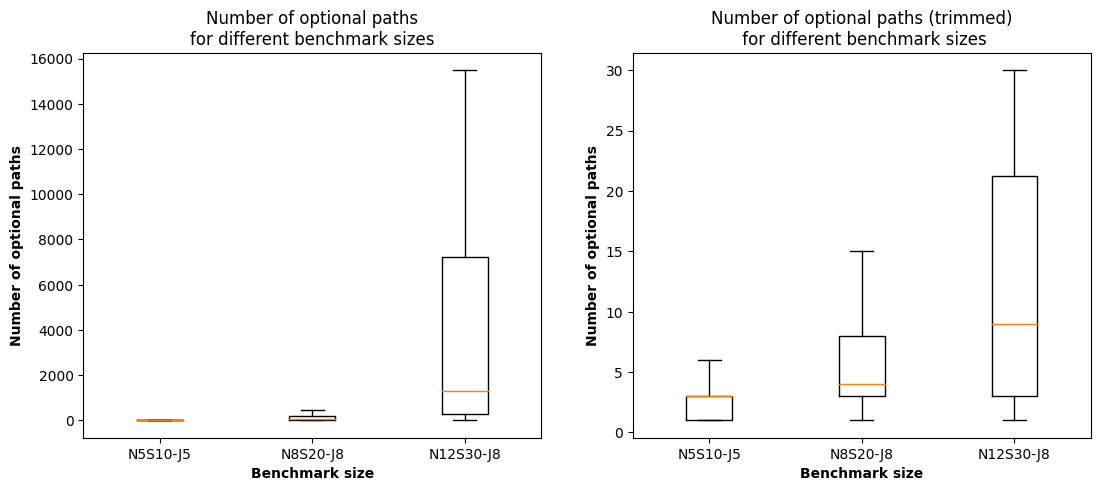

In [244]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html#matplotlib.pyplot.boxplot
fig, ax = plt.subplots(1,2, figsize=(13,5))
ax[0].boxplot(networks_num_opts_list, showfliers=False)
ax[0].set_xticklabels(benchmark_size_labels)
ax[0].set_xlabel("Benchmark size", fontweight='bold')
ax[0].set_ylabel("Number of optional paths", fontweight='bold')
ax[0].set_title("Number of optional paths\nfor different benchmark sizes")

ax[1].boxplot(networks_num_opts_trim_list, showfliers=False)
ax[1].set_xticklabels(benchmark_size_labels)
ax[1].set_xlabel("Benchmark size", fontweight='bold')
ax[1].set_ylabel("Number of optional paths", fontweight='bold')
ax[1].set_title("Number of optional paths (trimmed)\n for different benchmark sizes")
# ax[1].savefig("Thesis Benchmark Result/num_opts_trim.pdf")

plt.savefig("Thesis Benchmark Result/num_opts.pdf")


In [245]:
networks_free_run_time_list = [networks_free_run_time['Network N5S10PD6C1'], networks_free_run_time['Network N8S20PD6C2'], networks_free_run_time['Network N12S30PD6C3']]
networks_free_run_time_trim_list = [networks_free_run_time_trim['Network N5S10PD6C1'], networks_free_run_time_trim['Network N8S20PD6C2'], networks_free_run_time_trim['Network N12S30PD6C3']]

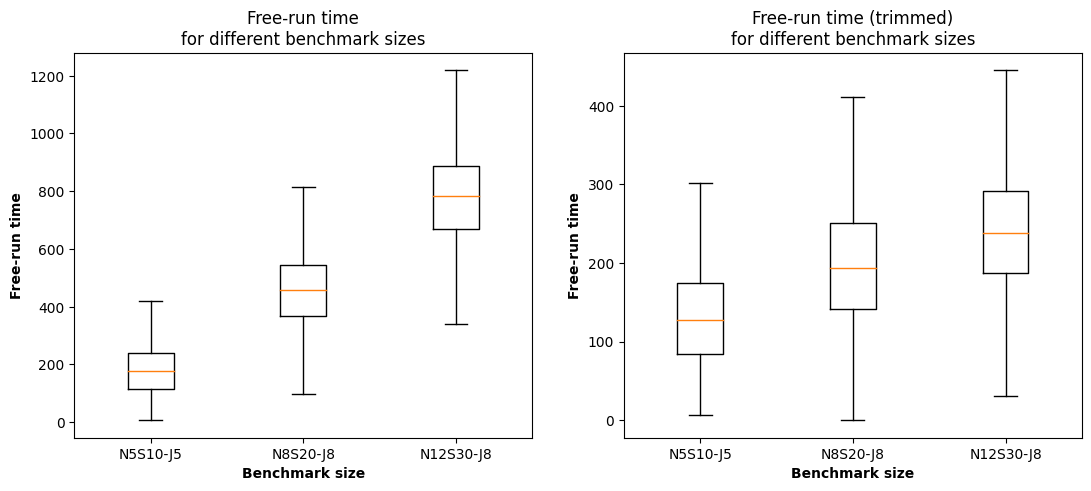

In [246]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html#matplotlib.pyplot.boxplot
fig, ax = plt.subplots(1,2, figsize=(13,5))

ax[0].boxplot(networks_free_run_time_list, showfliers=False)
ax[0].set_xticklabels(benchmark_size_labels)
ax[0].set_xlabel("Benchmark size", fontweight='bold')
ax[0].set_ylabel("Free-run time", fontweight='bold')
ax[0].set_title("Free-run time\nfor different benchmark sizes")

ax[1].boxplot(networks_free_run_time_trim_list, showfliers=False)
ax[1].set_xticklabels(benchmark_size_labels)
ax[1].set_xlabel("Benchmark size", fontweight='bold')
ax[1].set_ylabel("Free-run time", fontweight='bold')
ax[1].set_title("Free-run time (trimmed)\nfor different benchmark sizes")
# plt.savefig("Thesis Benchmark Result/free_run_trim.pdf")

plt.savefig("Thesis Benchmark Result/free_run.pdf")


In [247]:
networks_num_ops_list = [networks_num_ops['Network N5S10PD6C1'], networks_num_ops['Network N8S20PD6C2'], networks_num_ops['Network N12S30PD6C3']]
networks_num_ops_trim_list = [networks_num_ops_trim['Network N5S10PD6C1'], networks_num_ops_trim['Network N8S20PD6C2'], networks_num_ops_trim['Network N12S30PD6C3']]

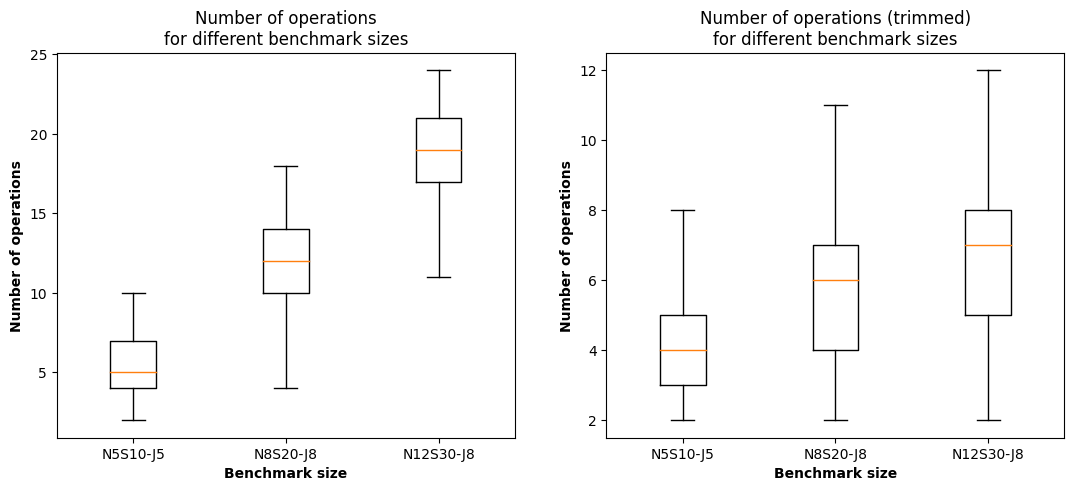

In [248]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html#matplotlib.pyplot.boxplot
fig, ax = plt.subplots(1,2, figsize=(13,5))

ax[0].boxplot(networks_num_ops_list, showfliers=False)
ax[0].set_xticklabels(benchmark_size_labels)
ax[0].set_xlabel("Benchmark size", fontweight='bold')
ax[0].set_ylabel("Number of operations", fontweight='bold')
ax[0].set_title("Number of operations\nfor different benchmark sizes")

ax[1].boxplot(networks_num_ops_trim_list, showfliers=False)
ax[1].set_xticklabels(benchmark_size_labels)
ax[1].set_xlabel("Benchmark size", fontweight='bold')
ax[1].set_ylabel("Number of operations", fontweight='bold')
ax[1].set_title("Number of operations (trimmed)\nfor different benchmark sizes")
# plt.savefig("Thesis Benchmark Result/free_run_trim.pdf")

plt.savefig("Thesis Benchmark Result/num_ops.pdf")


In [249]:
networks_total_num_ops_list = [networks_total_num_ops['Network N5S10PD6C1'], networks_total_num_ops['Network N8S20PD6C2'], networks_total_num_ops['Network N12S30PD6C3']]
networks_total_num_ops_trim_list = [networks_total_num_ops_trim['Network N5S10PD6C1'], networks_total_num_ops_trim['Network N8S20PD6C2'], networks_total_num_ops_trim['Network N12S30PD6C3']]

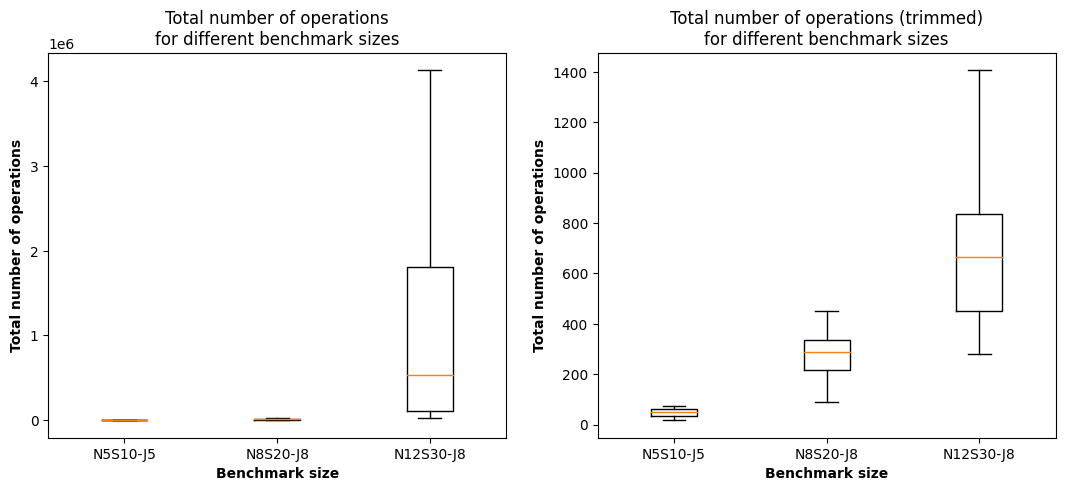

In [250]:
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html#matplotlib.pyplot.boxplot
fig, ax = plt.subplots(1,2, figsize=(13,5))

ax[0].boxplot(networks_total_num_ops_list, showfliers=False)
ax[0].set_xticklabels(benchmark_size_labels)
ax[0].set_xlabel("Benchmark size", fontweight='bold')
ax[0].set_ylabel("Total number of operations", fontweight='bold')
ax[0].set_title("Total number of operations\nfor different benchmark sizes")

ax[1].boxplot(networks_total_num_ops_trim_list, showfliers=False)
ax[1].set_xticklabels(benchmark_size_labels)
ax[1].set_xlabel("Benchmark size", fontweight='bold')
ax[1].set_ylabel("Total number of operations", fontweight='bold')
ax[1].set_title("Total number of operations (trimmed)\nfor different benchmark sizes")
# plt.savefig("Thesis Benchmark Result/free_run_trim.pdf")

plt.savefig("Thesis Benchmark Result/total_num_ops.pdf")


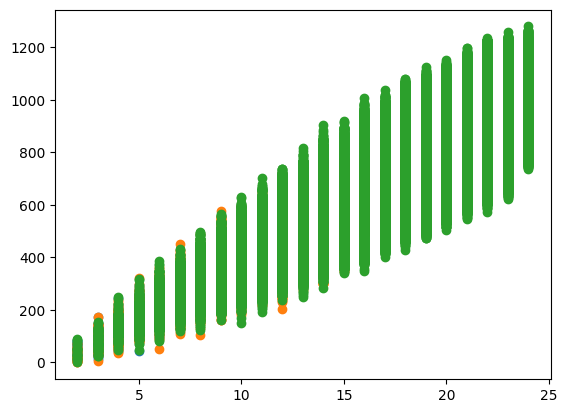

In [143]:
plt.scatter(networks_num_ops['Network N5S10PD6C1'], networks_free_run_time['Network N5S10PD6C1'], label="N5S10PD6C1")
plt.scatter(networks_num_ops['Network N8S20PD6C2'], networks_free_run_time['Network N8S20PD6C2'], label="N8S20PD6C2")
plt.scatter(networks_num_ops['Network N12S30PD6C3'], networks_free_run_time['Network N12S30PD6C3'], label="N12S30PD6C3")

In [92]:
# kde_large = gaussian_kde(networks_free_run_time['Network N12S30PD6C3'])
# kde_medium = gaussian_kde(networks_free_run_time['Network N8S20PD6C2'])
# kde_small = gaussian_kde(networks_free_run_time['Network N5S10PD6C1'])

kde_large = gaussian_kde(networks_num_opts_trim['Network N12S30PD6C3'])
kde_medium = gaussian_kde(networks_num_opts_trim['Network N8S20PD6C2'])
kde_small = gaussian_kde(networks_num_opts_trim['Network N5S10PD6C1'])

In [93]:
# height_large, edges_large = np.histogram(networks_free_run_time['Network N12S30PD6C3'], bins=50, density=True)
# centers_large = edges_large[:-1] + np.diff(edges_large)/2.
# height_medium, edges_medium = np.histogram(networks_free_run_time['Network N8S20PD6C2'], bins=50, density=True)
# centers_medium = edges_medium[:-1] + np.diff(edges_medium)/2.
# height_small, edges_small = np.histogram(networks_free_run_time['Network N5S10PD6C1'], bins=50, density=True)
# centers_small = edges_small[:-1] + np.diff(edges_small)/2.

height_large, edges_large = np.histogram(networks_num_opts_trim['Network N12S30PD6C3'], bins=50, density=True)
centers_large = edges_large[:-1] + np.diff(edges_large)/2.
height_medium, edges_medium = np.histogram(networks_num_opts_trim['Network N8S20PD6C2'], bins=50, density=True)
centers_medium = edges_medium[:-1] + np.diff(edges_medium)/2.
height_small, edges_small = np.histogram(networks_num_opts_trim['Network N5S10PD6C1'], bins=50, density=True)
centers_small = edges_small[:-1] + np.diff(edges_small)/2.

(-5.0, 50.0)

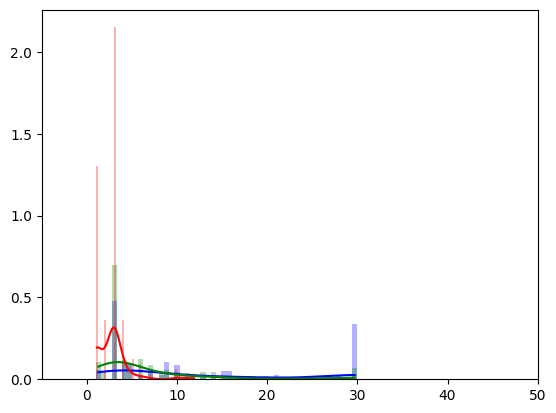

In [94]:
plt.bar(centers_large, height_large, width=edges_large[1]-edges_large[0], alpha=0.3, color='blue')
plt.plot(np.linspace(centers_large[0], centers_large[-1], 300), kde_large(np.linspace(centers_large[0], centers_large[-1], 300)), color='blue')

plt.bar(centers_medium, height_medium, width=edges_medium[1]-edges_medium[0], alpha=0.3, color='green')
plt.plot(np.linspace(centers_medium[0], centers_medium[-1], 300), kde_medium(np.linspace(centers_medium[0], centers_medium[-1], 300)), color='green')

plt.bar(centers_small, height_small, width=edges_small[1]-edges_small[0], alpha=0.3, color='red')
plt.plot(np.linspace(centers_small[0], centers_small[-1], 300), kde_small(np.linspace(centers_small[0], centers_small[-1], 300)), color='red')

plt.xlim(-5, 50)

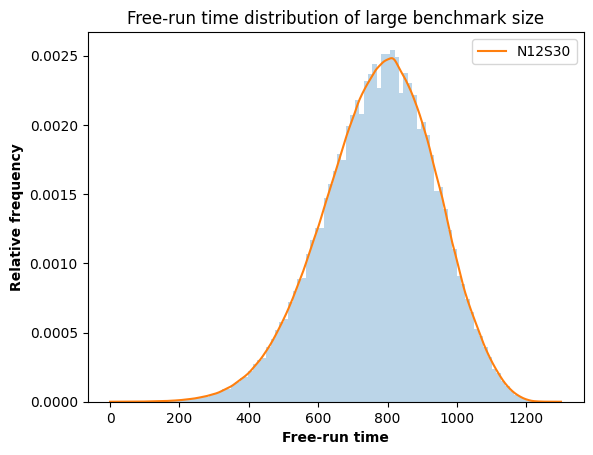

In [251]:
from scipy.stats import gaussian_kde
kde_large = gaussian_kde(networks_free_run_time['Network N12S30PD6C3'])
plt.hist(networks_free_run_time['Network N12S30PD6C3'], bins=100, density=True, alpha=0.3)
plt.plot(np.linspace(0, 1300, 1000), kde_large(np.linspace(0, 1300, 1000)), label="N12S30")
plt.xlabel("Free-run time", fontweight='bold')
plt.ylabel("Relative frequency", fontweight='bold')
plt.title("Free-run time distribution of large benchmark size")
plt.legend()
plt.savefig("Thesis Benchmark Result/large_free_run_time_dist.pdf")

In [214]:
raw = False

In [215]:
def get_DE_convergence(raw, path, fixed, inf):
    text = "fixed" if fixed else "flexible"
    text += " inf" if inf else " finite"
    results = []
    best = np.inf
    
    assert os.path.exists(os.path.join(path,f"DE {text}.pkl"))
    with open(os.path.join(path,f"DE {text}.pkl"), "br") as f:
        msol = pickle.load(f)
    best = min([run[1] for run in msol])
    
    if os.path.exists(os.path.join(path,f"CP {text}.pkl")):
        with open(os.path.join(path,f"CP {text}.pkl"), "br") as f:
            cp_msol = pickle.load(f)
        if cp_msol.get_solve_time() < 60:
            best = round(cp_msol.get_objective_value())
        else:
            if round(cp_msol.get_objective_value()) < best:
                best = round(cp_msol.get_objective_value())
        
    for run in msol:
        if raw:
            results += [log[0] for log in run[2]],
        else:
            results += [log[0]/best for log in run[2]],
    return results
    

In [216]:
from collections import defaultdict
# Benchmark_size, network ID, Fixed/Flexible, Inf/Finite, Solver, Objective, Time, J1, J2, J3, J4, J5, J6, J7, J8
result = []
benchmark_info = []
FOLDER = "Thesis Benchmark Results"

# from collections import defaultdict
networks_DE_fix_inf_convergence_results = defaultdict(list)
networks_DE_fix_fin_convergence_results = defaultdict(list)
networks_DE_flex_inf_convergence_results = defaultdict(list)
networks_DE_flex_fin_convergence_results = defaultdict(list)

for networks, NETWORK in get_next_network(FOLDER):
    # Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    # with open(os.path.join(path,"Benchmark.pkl"), "br") as f:
    #     Benchmark = pickle.load(f)
        # pickle.dump(Benchmark, f)
    # print(Benchmark.job_all_free_run_time[0])
    # break
    networks_DE_fix_inf_convergence_results[networks] += get_DE_convergence(raw, path, fixed=True, inf=True)
    networks_DE_fix_fin_convergence_results[networks] += get_DE_convergence(raw, path, fixed=True, inf=False)
    networks_DE_flex_inf_convergence_results[networks] += get_DE_convergence(raw, path, fixed=False, inf=True)
    networks_DE_flex_fin_convergence_results[networks] += get_DE_convergence(raw, path, fixed=False, inf=False)
    

['Network N12S30PD6C3', 'Network N5S10PD6C1', 'Network N8S20PD6C2']


In [217]:
networks_DE_fix_inf_convergence_results_align = defaultdict(list)
networks_DE_fix_fin_convergence_results_align = defaultdict(list)
networks_DE_flex_inf_convergence_results_align = defaultdict(list)
networks_DE_flex_fin_convergence_results_align = defaultdict(list)

In [218]:
def align_converge(converge_dict, converge_dict_align):
    iter_x = np.linspace(0, 10, 501)
    for k,v in converge_dict.items():
        for i in range(len(v)):
            converge_dict_align[k] += np.interp(iter_x, np.linspace(0, 10, len(v[i])), v[i]).tolist(),
    for k in converge_dict_align.keys():
        converge_dict_align[k] = np.array(converge_dict_align[k])
    

In [219]:
align_converge(networks_DE_fix_inf_convergence_results, networks_DE_fix_inf_convergence_results_align)
align_converge(networks_DE_fix_fin_convergence_results, networks_DE_fix_fin_convergence_results_align)
align_converge(networks_DE_flex_inf_convergence_results, networks_DE_flex_inf_convergence_results_align)
align_converge(networks_DE_flex_fin_convergence_results, networks_DE_flex_fin_convergence_results_align)


In [220]:
networks_DE_fix_inf_convergence_results_align.keys()

dict_keys(['Network N12S30PD6C3', 'Network N5S10PD6C1', 'Network N8S20PD6C2'])

In [221]:
# @njit(parallel=True, fastmath=True, cache=True)
def boostrap_convergence_mean(data, n=100, lb=0.025, ub=0.975):
    lb_results = np.zeros(data.shape[1])
    median_results = np.zeros(data.shape[1])
    ub_results = np.zeros(data.shape[1])
    for i in range(data.shape[1]):
        ids = np.random.randint(0, data.shape[0], n*data.shape[0])
        d = data[ids, i].reshape(n, data.shape[0])
        # print(ids.shape)
        result = d.mean(axis=1)
        
        lb_results[i],median_results[i],ub_results[i] = np.quantile(result, [lb, 0.5, ub])
        # lb_results[i] = np.mean(data[np.random.randint(0, len(data), len(data))], axis=0)
    return lb_results, median_results, ub_results

In [222]:
networks = ['Network N5S10PD6C1', 'Network N8S20PD6C2', 'Network N12S30PD6C3']

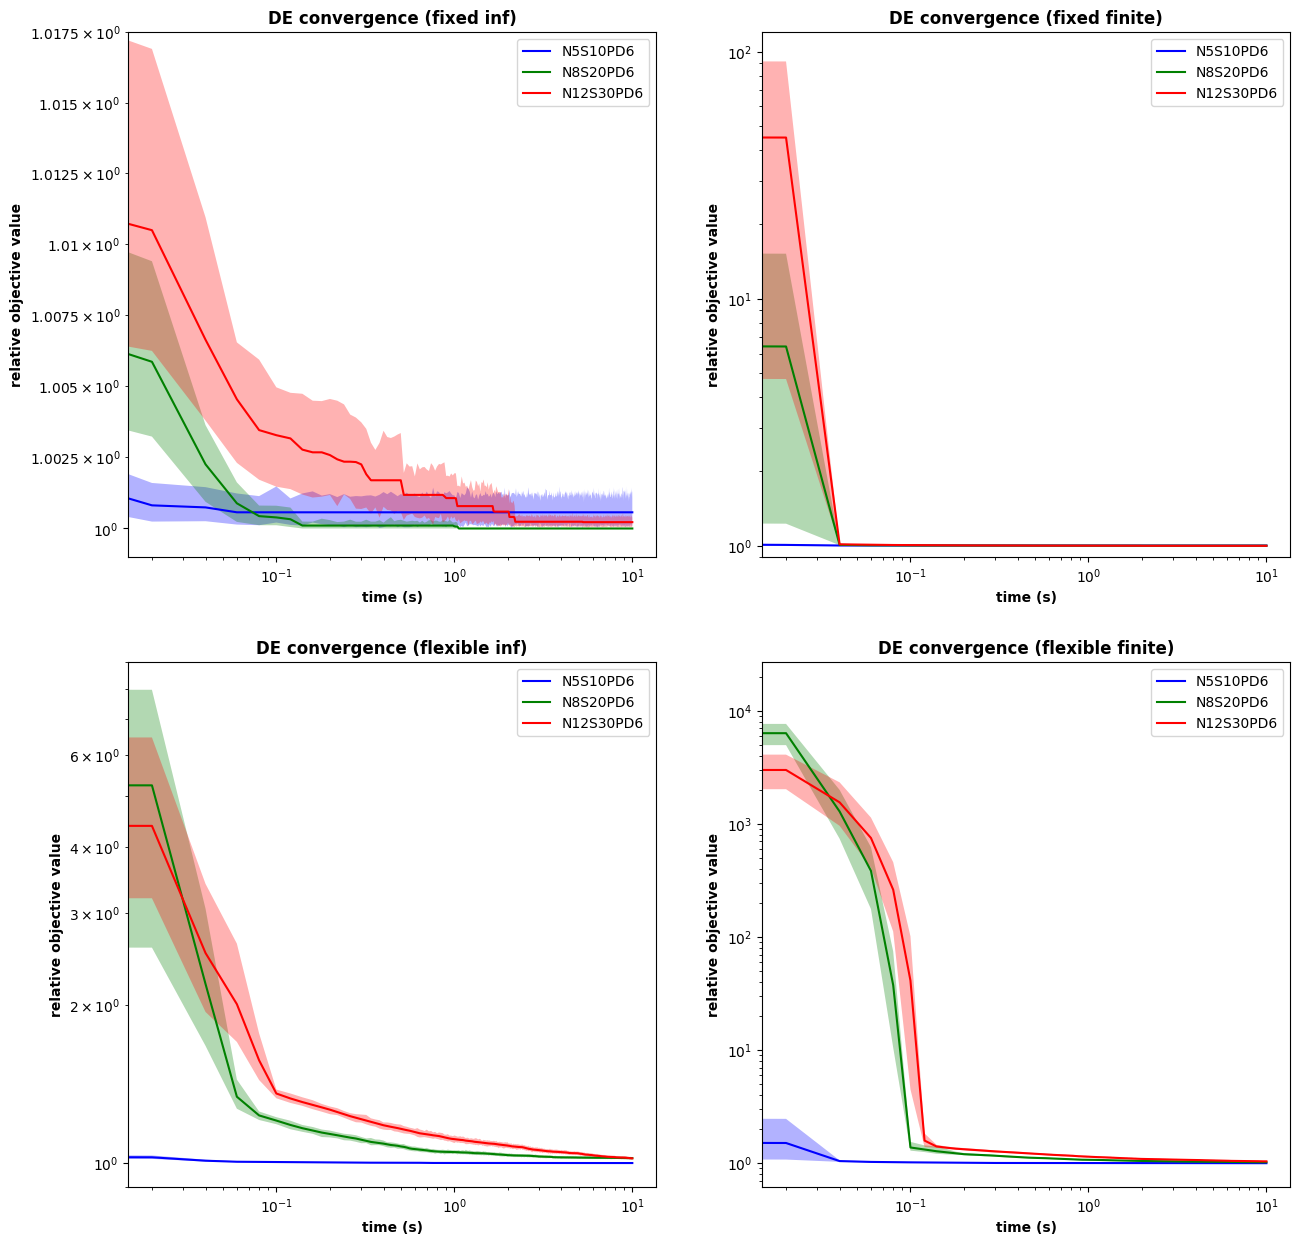

In [223]:
from scipy.signal import savgol_filter
fig, axes = plt.subplots(2,2, figsize=(15,15))
benchmark_size_labels = ["N5S10PD6", "N8S20PD6", "N12S30PD6"]
for i in range(2):
    for j in range(2):
        if i == 0:
            if j == 0:
                data = networks_DE_fix_inf_convergence_results_align
                text = "fixed inf"
            else:
                data = networks_DE_fix_fin_convergence_results_align
                text = "fixed finite"
        else:
            if j == 0:
                data = networks_DE_flex_inf_convergence_results_align
                text = "flexible inf"
            else:
                data = networks_DE_flex_fin_convergence_results_align
                text = "flexible finite"
        
        colors = ['blue', 'green', 'red']
        max_value = 0
        min_value = np.inf
        for k in range(3):  
            lb,med,ub = boostrap_convergence_mean(data[networks[k]])
            # lb = savgol_filter(lb, 51, 3)
            # ub = savgol_filter(ub, 51, 3)
            converge_mean = data[networks[k]].mean(axis=0)
            max_value = max(max_value, max(ub), max(converge_mean), max(lb))
            min_value = min(min_value, min(ub), min(converge_mean), min(lb))
            axes[i,j].fill_between(np.linspace(0, 10, 501), lb, ub, alpha=0.3, color=colors[k], edgecolor=None)
            axes[i,j].plot(np.linspace(0, 10, 501), converge_mean, color=colors[k], label=benchmark_size_labels[k])
        
        axes[i,j].set_xlabel("time (s)", fontweight='bold')
        if raw:
            axes[i,j].set_ylabel("objective value", fontweight='bold')
        else:
            axes[i,j].set_ylabel("relative objective value", fontweight='bold')
        axes[i,j].set_title(f"DE convergence ({text})", fontweight='bold')
        axes[i,j].legend()
        axes[i,j].loglog()
        # axes[i,j].set_ylim(min_value*0.95, max_value*1.05)
        # print(max_value)
        # axes[i,j].set_xscale('log')

if raw:
    axes[0,0].set_ylim(200, 400)
    axes[0,1].set_ylim(200, 5e4)
else:
    axes[0,0].set_ylim(0.999, 1.0175)
    axes[0,1].set_ylim(0.9, 120)
    axes[1,0].set_ylim(0.9, 9)
    

if raw:
    plt.savefig("Thesis Benchmark Result/DE convergence (raw).pdf")
else:
    plt.savefig("Thesis Benchmark Result/DE convergence.pdf")
        

In [ ]:
lb,med,ub = boostrap_convergence_mean(networks_DE_fix_inf_convergence_results_align[networks[0]])
converge_mean = networks_DE_fix_inf_convergence_results_align[networks[0]].mean(axis=0)
plt.fill_between(np.linspace(0, 10, 501), lb, ub, alpha=0.3, color='blue')
plt.plot(np.linspace(0, 10, 501), converge_mean, color='blue', label=networks[0][:-2])

lb,med,ub = boostrap_convergence_mean(networks_DE_fix_fin_convergence_results_align[networks[0]])



plt.loglog()

In [45]:
lb,med,ub = boostrap_convergence_mean(networks_DE_flex_inf_convergence_results_align['Network N5S10PD6C1'])
converge_mean = networks_DE_flex_inf_convergence_results_align['Network N5S10PD6C1'].mean(axis=0)

[]

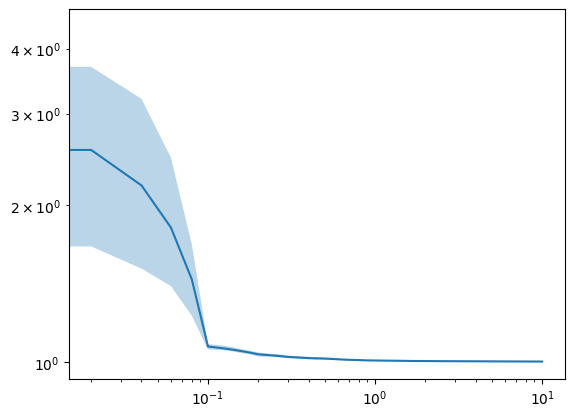

In [46]:
plt.fill_between(np.linspace(0, 10, 501), lb, ub, alpha=0.3)
# plt.plot(np.linspace(0, 10, 501), med)
plt.plot(np.linspace(0, 10, 501), converge_mean)
plt.loglog()

In [199]:
line1 = np.array(networks_DE_fix_fin_convergence_results_align['Network N12S30PD6C3']).mean(axis=0)
line2 = np.array(networks_DE_fix_fin_convergence_results_align['Network N8S20PD6C2']).mean(axis=0)
line3 = np.array(networks_DE_fix_fin_convergence_results_align['Network N5S10PD6C1']).mean(axis=0)

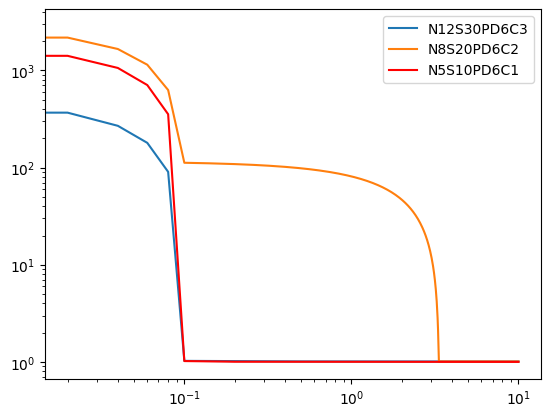

In [205]:
iter_x = np.linspace(0, 10, 501)
plt.plot(iter_x, line1, label="N12S30PD6C3")
plt.plot(iter_x, line2, label="N8S20PD6C2")
plt.plot(iter_x, line3, label="N5S10PD6C1", color='red')
plt.loglog()
# plt.xlim(-0.1,6)
plt.legend()

# Special Case

In [7]:
benchmark_size = ['Network N5S10PD6C1', 'Network N8S20PD6C2', 'Network N12S30PD6C3']
benchmark_size_labels = ["N5S10-J5", "N8S20-J8", "N12S30-J8"]

In [8]:
fixed_flex = ['fixed', 'fixed', 'flexible','flexible']
inf_fin = ['inf', 'finite', 'inf','finite']
solvers = ["CP", "IP", "DE"]
solver_labels = ["CP", "IP", "DE"]
problem_types = [[]]*len(fixed_flex)

In [9]:
for i in range(len(fixed_flex)):
    objV_time_results = []
    for solver in solvers:
        objV_time_result = []
        # if solver == "CP" or solver == "IP":
        #     objV_time_result = [solver]
        # else:
        #     objV_time_result = ["PermDE"]
        for j in range(len(benchmark_size)):
            tmp_df = df[(df["Benchmark Size"] == benchmark_size[j]) & (df["Fixed/Flexible"] == fixed_flex[i]) & (df["Inf/Finite"] == inf_fin[i])]
            if solver == "CP" or solver == "IP":
                tmp = tmp_df[(tmp_df["Solver"] == solver)]
                count = (tmp["Solving Time"] < 60).sum()
                total = tmp.shape[0]
                avg = tmp["Solving Time"].mean()
                objV_time_result += [f"{round(count/total, 3)} ({count}/{total})", round(avg,2)]
            else:
                count = 0
                total = 0
                avg = 0
                for net in tmp_df["Network ID"].unique():
                    tmp = tmp_df[(tmp_df["Solver"] == solver) & (tmp_df["Network ID"] == net)]
                    cp_result = tmp_df[(tmp_df["Solver"] == solvers[0]) & (tmp_df["Network ID"] == net)]
                    ip_result = tmp_df[(tmp_df["Solver"] == solvers[1]) & (tmp_df["Network ID"] == net)]
                    obj = min(cp_result["Objective Value"].values[0], ip_result["Objective Value"].values[0])
                    count += (tmp["Objective Value"] <= obj).sum()
                    total += tmp.shape[0]
                    avg += tmp["Solving Time"].sum()
                avg /= total
                objV_time_result += [f"{round(count/total, 3)} ({count}/{total})", round(avg,2)]
                
        objV_time_results += objV_time_result,
    problem_types[i] = objV_time_results
# df[(df["Benchmark Size"] == benchmark_size[0]) & (df["Solver"] == "CP") & (df["Fixed/Flexible"] == "fixed") & (df["Inf/Finite"] == "inf")]

In [10]:
for i in range(len(fixed_flex)):
    problem_type_df = pd.DataFrame(problem_types[i], index=solver_labels)
    # problem_type_df.set_index(0, inplace=True, drop=True)
    problem_type_df.columns = pd.MultiIndex.from_product([benchmark_size_labels, ["search rate", "avg time (s)"]])
    print(problem_type_df.to_latex())

\begin{tabular}{llrlrlr}
\toprule
{} & \multicolumn{2}{l}{N5S10-J5} & \multicolumn{2}{l}{N8S20-J8} & \multicolumn{2}{l}{N12S30-J8} \\
{} &     search rate & avg time (s) &      search rate & avg time (s) &      search rate & avg time (s) \\
\midrule
CP &     1.0 (30/30) &         0.75 &      1.0 (30/30) &         2.90 &      1.0 (30/30) &         4.83 \\
IP &     1.0 (30/30) &         0.02 &      1.0 (30/30) &         0.33 &      1.0 (30/30) &         1.38 \\
DE &  0.96 (144/150) &        10.00 &  0.967 (145/150) &        10.01 &  0.933 (140/150) &        10.01 \\
\bottomrule
\end{tabular}

\begin{tabular}{llrlrlr}
\toprule
{} & \multicolumn{2}{l}{N5S10-J5} & \multicolumn{2}{l}{N8S20-J8} & \multicolumn{2}{l}{N12S30-J8} \\
{} &      search rate & avg time (s) &     search rate & avg time (s) &      search rate & avg time (s) \\
\midrule
CP &      1.0 (30/30) &         0.91 &     1.0 (30/30) &         3.35 &      1.0 (30/30) &         5.10 \\
IP &      1.0 (30/30) &         0.04 &   0.96

In [272]:
df[(df["Benchmark Size"] == benchmark_size[0]) & (df["Solver"] == "CP") & (df["Fixed/Flexible"] == "fixed") & (df["Inf/Finite"] == "inf")]


,Benchmark Size,Network ID,Fixed/Flexible,Inf/Finite,Solver,Objective Value,Solving Time
840,Network N5S10PD6C1,network-1,fixed,inf,CP,213.0,0.392
868,Network N5S10PD6C1,network-10,fixed,inf,CP,225.0,1.103
896,Network N5S10PD6C1,network-11,fixed,inf,CP,186.0,0.572
924,Network N5S10PD6C1,network-12,fixed,inf,CP,420.0,1.011
952,Network N5S10PD6C1,network-13,fixed,inf,CP,213.0,0.579
980,Network N5S10PD6C1,network-14,fixed,inf,CP,192.0,0.810
1008,Network N5S10PD6C1,network-15,fixed,inf,CP,252.0,0.237
1036,Network N5S10PD6C1,network-16,fixed,inf,CP,287.0,0.676
1064,Network N5S10PD6C1,network-17,fixed,inf,CP,188.0,0.428
1092,Network N5S10PD6C1,network-18,fixed,inf,CP,274.0,1.153


In [22]:
def get_result_special(result, path, fixed, inf, random_one):
    text = "fixed" if fixed else "flexible"
    text += " random one" if random_one else ""
    text += " inf" if inf else " finite"
    print(get_time(), text)
    files = os.listdir(path)
    solvers = ["CP", "IP", "DE"]
    
    results = []
    for solver in solvers:
        solver_files = sorted([f for f in files if (solver in f) and (text in f)])
        solver_results = []
        for solver_file in solver_files:
            if solver == "CP":
                with open(os.path.join(path,solver_file), "br") as f:
                    msol = pickle.load(f)
                solver_results += [msol.get_objective_value(), msol.get_solve_time()],
            elif solver == "IP":
                with open(os.path.join(path,solver_file), "br") as f:
                    msol = json.load(f)
                solver_results += [round(float(msol["CPLEXSolution"]["header"]["objectiveValue"])), float(msol["time"])],
            else:
                with open(os.path.join(path,solver_file), "br") as f:
                    msol = pickle.load(f)
                for i in range(len(msol)):
                    solver_results += [msol[i][1], msol[i][0]],
        results += solver_results,
    return results
    
    # if os.path.exists(os.path.join(path,f"CP {text}.pkl")):
    #     with open(os.path.join(path,f"CP {text}.pkl"), "br") as f:
    #         msol = pickle.load(f)
    #     # print(msol.get_solve_time(), msol.get_objective_value())
    #     result += (path.split("/")[1:]+text.split(" ")+["CP", round(msol.get_objective_value()), msol.get_solve_time()]),
    #     # result += (path.split("/")[1:]+text.split(" ")+["CP", msol.get_objective_value(), msol.get_solve_time()] + jobs_num_opts.tolist()),
    #     # pickle.dump(msol, f)
    # else:
    #     result += (path.split("/")[1:]+text.split(" ")+["CP", np.nan, np.nan]),
        
    # if os.path.exists(os.path.join(path,f"IP {text} sol.json")):
    #     with open(os.path.join(path,f"IP {text} sol.json"), "br") as f:
    #         msol = json.load(f)
    #         # msol = pickle.load(f)
    #     obj = msol["CPLEXSolution"]["header"]["objectiveValue"]
    #     solve_time = msol["time"]
    #     result += (path.split("/")[1:]+text.split(" ")+["IP", round(float(obj)), solve_time]),
    #     # result += (path.split("/")[1:]+text.split(" ")+["IP", obj, solve_time] + jobs_num_opts.tolist()),
    # else:
    #     result += (path.split("/")[1:]+text.split(" ")+["IP", np.nan, np.nan]),
        
    # if os.path.exists(os.path.join(path,f"DE {text}.pkl")):
    #     with open(os.path.join(path,f"DE {text}.pkl"), "br") as f:
    #         msol = pickle.load(f)
    #     for i in range(len(msol)):
    #         result += (path.split("/")[1:]+text.split(" ")+["DE", round(msol[i][1]), msol[i][0]]),
    #         # result += (path.split("/")[1:]+text.split(" ")+["DE", msol[i][1], msol[i][0]] + jobs_num_opts.tolist()),
    # else:
    #     result += (path.split("/")[1:]+text.split(" ")+["DE", np.nan, np.nan]),

In [23]:
# Benchmark_size, network ID, Fixed/Flexible, Inf/Finite, Solver, Objective, Time, J1, J2, J3, J4, J5, J6, J7, J8
result = []
benchmark_info = []
FOLDER = "Thesis Benchmark Results (Special Case)"

for networks, NETWORK in get_next_network(FOLDER):
    # Benchmark = MHSP_Benchmark(data, max_num_jobs = 8)
    path = os.path.join(FOLDER,networks,NETWORK)
    print(path)
    # jobs_num_opts = np.full(8, np.nan)
    # jobs_num_opts[:len(Benchmark.job_all_free_run_time)] = np.array([len(r) for r in Benchmark.job_all_free_run_time])
    # benchmark_info += (path.split("/")[1:] + jobs_num_opts.tolist()),
    fixed_fin = get_result_special(result, path, fixed=True, inf=False, random_one=False)
    fixed_fin_random_one = get_result_special(result, path, fixed=True, inf=False, random_one=True)
    flex_fin = get_result_special(result, path, fixed=False, inf=False, random_one=False)
    # print(get_result_special(result, path, fixed=True, inf=False, random_one=False))
    # get_result(result, path, fixed=True, inf=False)
    # get_result(result, path, fixed=False, inf=True)
    # get_result(result, path, fixed=False, inf=False)
    # print(len(Benchmark.job_all_paths[0]))
    # print(path) 

['Network N12S30PD6C3']
Thesis Benchmark Results (Special Case)/Network N12S30PD6C3/network-10
2024-01-18 22:53:11 fixed finite
2024-01-18 22:53:11 fixed random one finite
2024-01-18 22:53:11 flexible finite


In [27]:
special_result = [fixed_fin, fixed_fin_random_one, flex_fin]

In [35]:
special_result[2]

[[[493, 60.315]],
 [],
 [[502.0, 10.06540340000356],
  [494.0, 10.0717267],
  [491.0, 10.036214899999322],
  [493.0, 10.068393299996387],
  [491.0, 10.088402699999278]]]

In [52]:
solver_results = []
for i in range(len(solvers)):
    solver_result = []
    for j in range(len(special_result)):
        if special_result[j][i] == []:
            solver_result += [np.nan, np.nan, np.nan]
        else:
            r = np.array(special_result[j][i])
            solver_result += [round(r[:,0].min())] + (np.round(r.mean(axis=0),2).tolist())
    solver_results += solver_result,

In [53]:
special_problem_type_df = pd.DataFrame(solver_results, index=solver_labels)
# problem_type_df.set_index(0, inplace=True, drop=True)
special_problem_type_df.columns = pd.MultiIndex.from_product([["Fixed/Finite", "Fixed/Finite/Random", "Flexible/Finite"], ["best makespan", "(avg) makespan", "avg time (s)"]])
print(special_problem_type_df.to_latex())


\begin{tabular}{lrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{Fixed/Finite} & \multicolumn{3}{l}{Fixed/Finite/Random} & \multicolumn{3}{l}{Flexible/Finite} \\
{} & best makespan & (avg) makespan & avg time (s) &       best makespan & (avg) makespan & avg time (s) &   best makespan & (avg) makespan & avg time (s) \\
\midrule
CP &           708 &          708.0 &         7.31 &                 532 &         610.90 &        17.08 &           493.0 &          493.0 &        60.32 \\
IP &           708 &          708.0 &         1.56 &                 532 &         601.40 &        13.69 &             NaN &            NaN &          NaN \\
DE &           708 &          708.0 &        10.00 &                 532 &         618.88 &        10.01 &           491.0 &          494.2 &        10.07 \\
\bottomrule
\end{tabular}



In [93]:
path = "Thesis Benchmark/Network N12S30PD6C3/network-10"
JOB_FILE = [s for s in os.listdir(path) if s.startswith("Special")][0]
FILENAME = os.path.join(path,JOB_FILE)
print(FILENAME)
with open(FILENAME) as f:
    data = json.loads(f.read())
with open(os.path.join(path,"Network config.json")) as f:
    data.update(json.loads(f.read()))
Benchmark = MHSP_Benchmark(data, max_num_jobs = 5)
Benchmark.InfCapacity = False

Thesis Benchmark/Network N12S30PD6C3/network-10/Special Flexible J8.json


100%|██████████| 5/5 [00:00<00:00,  6.39it/s]


In [94]:
DE_result_path = "Thesis Benchmark Results (Special Case)/Network N12S30PD6C3/network-10/Special DE flexible finite.pkl"
with open(DE_result_path, "br") as f:
    msol = pickle.load(f)
sol_flex = msol[2][4][2]

In [95]:
DE_result_path = "Thesis Benchmark Results (Special Case)/Network N12S30PD6C3/network-10/Special DE fixed finite.pkl"
with open(DE_result_path, "br") as f:
    msol = pickle.load(f)
sol_fix = msol[0][4][0]

In [96]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [97]:
job_colors = get_cmap(Benchmark.num_jobs, "winter")

0 48 83
0 139 167
0 320 385
0 397 448
1 24 36
1 83 111
1 190 255
1 267 318
2 151 195
2 251 320
2 450 515
2 527 578
3 0 12
3 27 55
3 60 125
3 137 188
4 95 139
4 195 223
4 580 645
4 657 708
0 24 66
0 79 136
0 146 187
0 297 346
0 380 417
1 24 24
1 70 95
1 96 121
1 184 211
1 224 248
1 306 343
2 108 127
2 130 155
2 167 209
2 220 268
2 286 313
2 370 394
2 454 491
3 0 12
3 27 55
3 60 103
3 116 140
3 158 195
4 0 0
4 20 45
4 46 71
4 130 157
4 170 194
4 232 269


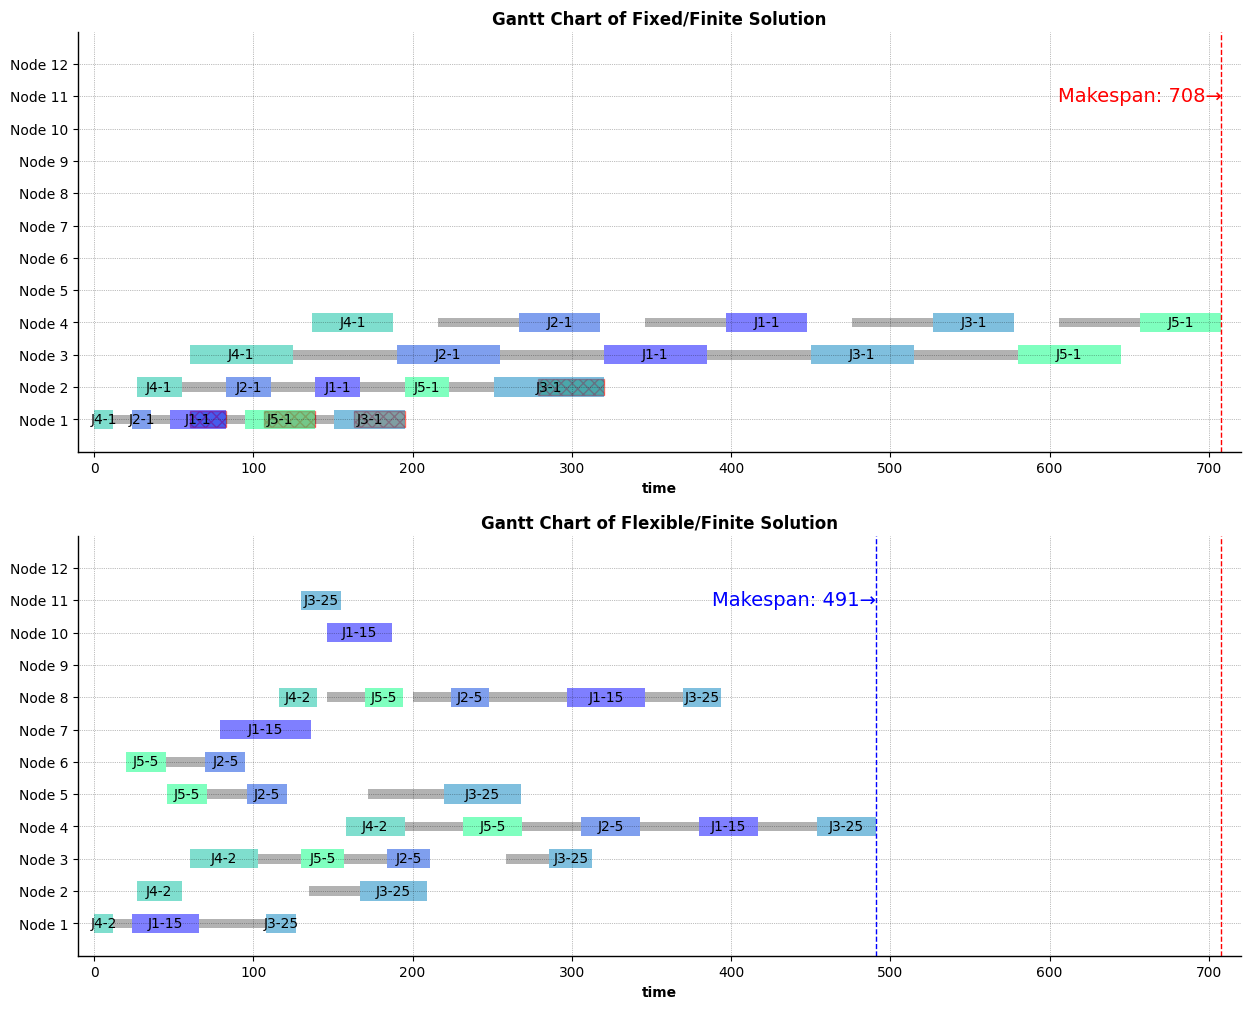

In [231]:
y_min = 10
plt.rcParams['figure.figsize'] = [15, 12]
fig, axes = plt.subplots(2,1)


ax = axes[0]
Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 1, factor=2)
DE = DE_Solver(Benchmark)
selected_path_fix, start_time_fix, end_time_fix = DE.Decode(sol_fix)
node_ops = [[] for _ in range(Benchmark.num_nodes)]

for j in range(Benchmark.num_jobs):
    for i in range(0,len(Benchmark.jobs[j][selected_path_fix[j]]),2):
        op = Benchmark.jobs[j][selected_path_fix[j]][i]
        start = start_time_fix[j][i//2]
        end = end_time_fix[j][i//2]
        print(op.Job, start, end)
        size = end-start
        if size == 0:
            continue
        n = op.Node
        opt = op.Option
        f = op.From
        t = op.To
        node_ops[n] += (start,op),
        ax.barh(y=y_min+n*10, left=start, width=size, height=6, color=job_colors(op.Job), alpha=0.5)
        
        min_size = Benchmark.node_from_to[n][f][t]
        if size > min_size:
            extra = size - min_size
            ax.barh(y=y_min+n*10, left=end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
        
        text_coord_x = start + size/2
        ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1}", ha='center', va='center', fontsize=10)
        # ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1} [{f+1}→{t+1}]", ha='center', va='center', fontsize=10)
        # print(intv.get_name(), intv.get_value())
        
    # print(start_time[j], end_time[j])

node_ops = [sorted(ops, key=lambda p:(p[0])) for ops in node_ops]

for n in range(len(node_ops)):
    for i in range(1, len(node_ops[n])):
        f = node_ops[n][i-1][1].To
        t = node_ops[n][i][1].From
        ax.barh(y=y_min+n*10, left=node_ops[n][i][0]-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=3, color="k", alpha=0.3)

ax.set_ylim(0, 10*(Benchmark.num_nodes+1))
ax.set_xlim(-10, 720)
ax.set_xlabel('time', fontweight="bold")
ax.set_title("Gantt Chart of Fixed/Finite Solution", fontweight="bold")
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.spines["top"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_yticks([y_min+10*n for n in range(Benchmark.num_nodes)])
ax.set_yticklabels([f"Node {i+1}" for i in range(Benchmark.num_nodes)])
ax.axvline(max([e[-1] for e in end_time_fix]), color='r', linewidth=1, linestyle="dashed")
ax.text(max([e[-1] for e in end_time_fix]), 10*(Benchmark.num_nodes-1), f"Makespan: {max([e[-1] for e in end_time_fix])}→", ha='right', va='center', fontsize=14, color='r')


ax = axes[1]
Benchmark.GenerateOperations(min_optional_path = 3, max_optional_path = 30, factor=2)
DE = DE_Solver(Benchmark)
selected_path_flex, start_time_flex, end_time_flex = DE.Decode(sol_flex)
node_ops = [[] for _ in range(Benchmark.num_nodes)]

for j in range(Benchmark.num_jobs):
    for i in range(0,len(Benchmark.jobs[j][selected_path_flex[j]]),2):
        op = Benchmark.jobs[j][selected_path_flex[j]][i]
        start = start_time_flex[j][i//2]
        end = end_time_flex[j][i//2]
        print(op.Job, start, end)
        size = end-start
        if size == 0:
            continue
        n = op.Node
        opt = op.Option
        f = op.From
        t = op.To
        node_ops[n] += (start,op),
        ax.barh(y=y_min+n*10, left=start, width=size, height=6, color=job_colors(op.Job), alpha=0.5)
        
        min_size = Benchmark.node_from_to[n][f][t]
        if size > min_size:
            extra = size - min_size
            ax.barh(y=y_min+n*10, left=end-extra, width=extra, height=5, color=None, edgecolor='red', zorder = 0, alpha=0.5, hatch='xxx')
        
        text_coord_x = start + size/2
        ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1}", ha='center', va='center', fontsize=10)
        # ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1} [{f+1}→{t+1}]", ha='center', va='center', fontsize=10)
        # print(intv.get_name(), intv.get_value())
        
    # print(start_time[j], end_time[j])

node_ops = [sorted(ops, key=lambda p:(p[0])) for ops in node_ops]

for n in range(len(node_ops)):
    for i in range(1, len(node_ops[n])):
        f = node_ops[n][i-1][1].To
        t = node_ops[n][i][1].From
        ax.barh(y=y_min+n*10, left=node_ops[n][i][0]-Benchmark.node_from_to[n][f][t], width=Benchmark.node_from_to[n][f][t], height=3, color="k", alpha=0.3)

ax.set_ylim(0, 10*(Benchmark.num_nodes+1))
ax.set_xlim(-10, 720)
ax.set_xlabel('time', fontweight="bold")
ax.set_title("\n\nGantt Chart of Flexible/Finite Solution", fontweight="bold")
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.spines["top"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_yticks([y_min+10*n for n in range(Benchmark.num_nodes)])
ax.set_yticklabels([f"Node {i+1}" for i in range(Benchmark.num_nodes)])
ax.axvline(max([e[-1] for e in end_time_fix]), color='r', linewidth=1, linestyle="dashed")
# ax.text(max([e[-1] for e in end_time_fix]), 10*(Benchmark.num_nodes-1), f"Makespan: {max([e[-1] for e in end_time_fix])}→", ha='right', va='center', fontsize=14, color='r')
ax.axvline(max([e[-1] for e in end_time_flex]), color='b', linewidth=1, linestyle="dashed")
ax.text(max([e[-1] for e in end_time_flex]), 10*(Benchmark.num_nodes-1), f"Makespan: {max([e[-1] for e in end_time_flex])}→", ha='right', va='center', fontsize=14, color='b')


plt.savefig("Thesis Benchmark Result/Special Case Compare.pdf")
# print(FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
# print(FOLDER)


['J2', 'Option', '2', 'Operation', '4', '(Node', '0', 'From', '7', 'To', '3)']
J2 Option 2 Operation 4 (Node 0 From 7 To 3) IntervalVarValue(start=96, end=128, size=32)
[<docplex.cp.solution.CpoIntervalVarSolution object at 0x134133b00>, <docplex.cp.solution.CpoIntervalVarSolution object at 0x1341323e0>]
['J4', 'Option', '1', 'Operation', '0', '(Node', '1', 'From', '5', 'To', '1)']
J4 Option 1 Operation 0 (Node 1 From 5 To 1) IntervalVarValue(start=0, end=37, size=37)
['J2', 'Option', '2', 'Operation', '2', '(Node', '1', 'From', '0', 'To', '5)']
J2 Option 2 Operation 2 (Node 1 From 0 To 5) IntervalVarValue(start=73, end=86, size=13)
[<docplex.cp.solution.CpoIntervalVarSolution object at 0x134132340>, <docplex.cp.solution.CpoIntervalVarSolution object at 0x134132520>]
['J2', 'Option', '2', 'Operation', '0', '(Node', '2', 'From', '0', 'To', '4)']
J2 Option 2 Operation 0 (Node 2 From 0 To 4) IntervalVarValue(start=0, end=58, size=58)
['J2', 'Option', '2', 'Operation', '6', '(Node', '2', '

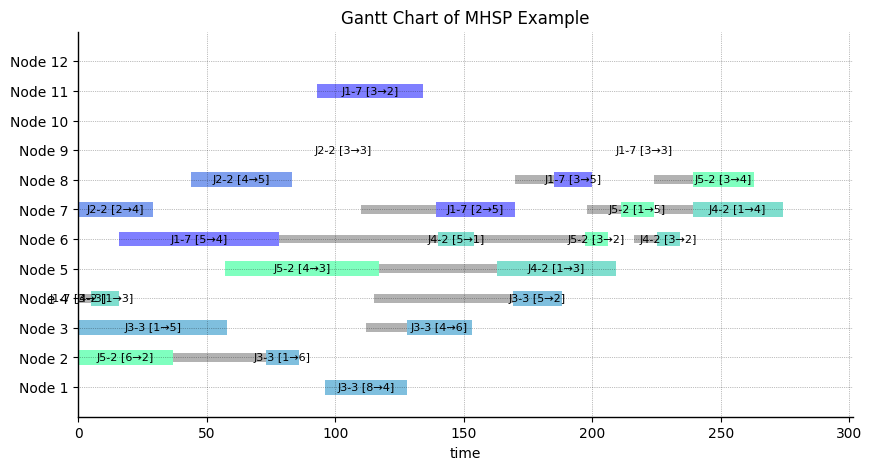

In [ ]:
y_min = 10
fig, ax = plt.subplots()



for n, NODE in enumerate(NODEs):
    intvs = msol.get_var_solution(NODE.seq.get_name()).get_value()
    print(intvs)
    # ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
    for intv in intvs:
        text = intv.get_name().split(" ")
        j = int(text[0][1:])
        opt = int(text[2])
        print(text)
        f = int(text[8])
        t = int(text[10][:-1])
        c = job_colors(j)
        v = intv.get_value()
        ax.barh(y=y_min+n*10, left=v.start, width=v.size, height=5, color=c, alpha=0.5)
        
        text_coord_x = v.start + v.size/2
        ax.text(text_coord_x, y_min+n*10, f"J{j+1}-{opt+1} [{f+1}→{t+1}]", ha='center', va='center', fontsize=8)
        print(intv.get_name(), intv.get_value())
        
    if len(intvs) == 1:
        continue
    for i in range(1, len(intvs)):
        first_intv = intvs[i-1].get_value()
        second_intv = intvs[i].get_value()
        f = int(intvs[i-1].get_name().split(" ")[10][:-1])
        t = int(intvs[i].get_name().split(" ")[8])
        
        ax.barh(y=y_min+n*10, left=second_intv.start-node_from_to[NODE.id][f][t], width=node_from_to[NODE.id][f][t], height=3, color="k", alpha=0.3)
        
    
        
    
# for j,JOB in enumerate(JOBs):
#     for i in range(len(JOB.option_intv)):
#         if msol.get_var_solution(JOB.option_intv[i].get_name()).is_present():
#             operation_sol = [msol.get_var_solution(intv).get_value() for intv in JOB.operation_intv[i]]
#         break
#     x = [(sol.start, sol.size) for sol in operation_sol]
#     s = [(sol.start, sol.end) for sol in operation_sol]
#     print(i)
#     print(x)
#     print(s)
#     ops = JOB.options[i]
#     # ops = jobs[j][i]
#     for i in range(len(x)):
#         text_coord_x = x[i][0] + x[i][1]/2
#         if i % 2 == 0:
#             ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='w', alpha=0, edgecolor="k", linewidth=3)
#             ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:orange', alpha=0.45)
#             ax.text(text_coord_x, y_min+j*10, f"{ops[i].From} {ops[i].To} {ops[i].To}", ha='center', va='center', fontsize=10)
#         else:
#             ax.barh(y=y_min+j*10, left=x[i][0], width=x[i][1], height=5, color='tab:blue', alpha=0.45)
#             ax.text(text_coord_x, y_min+j*10, f"{ops[i].Inbound_Node} {ops[i].Inbound_pd} {ops[i].Outbound_Node} {ops[i].Outbound_pd}", ha='center', va='center', fontsize=10)

#             # ax.broken_barh(x[i], (y_min+j*10, 9), facecolors='tab:blue', alpha=0.45)
            
#     # ax.broken_barh(x, (y_min+j*10, 9), facecolors='tab:blue', alpha=0.45)
    
plt.rcParams['figure.figsize'] = [100, 50]
ax.set_ylim(0, 10*(num_nodes+1))
ax.set_xlim(0, msol.get_objective_value()*1.1)
ax.set_xlabel('time')
ax.set_title("Gantt Chart of MHSP Example")
ax.spines["bottom"].set_linewidth(1)
ax.spines["left"].set_linewidth(1)
ax.spines["top"].set_linewidth(0)
ax.spines["right"].set_linewidth(0)
ax.grid(color='k', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_yticks([y_min+10*n for n in range(num_nodes)])
ax.set_yticklabels([f"Node {i+1}" for i in range(num_nodes)])
print(FOLDER)
# ax.set_yticklabels(['Bill', 'Jim'])
# ax.annotate('emty-car moving time', (43, 28),
#             xytext=(0.6, 0.3), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05, alpha=0.7),
#             fontsize=16,
#             horizontalalignment='right', verticalalignment='center')
print(FOLDER)
# plt.savefig(f"{FOLDER}/Gantt Chart of MHSP Example.pdf", bbox_inches='tight')

# Improvement

In [130]:
result_df = pd.read_csv("Thesis Benchmark Result/result.csv")
# df.to_csv("Thesis Benchmark Result/result.csv", index=False)

In [142]:
best_result = result_df.sort_values(["Benchmark Size", "Fixed/Flexible", "Inf/Finite", "Network ID", "Objective Value", "Solving Time"]).groupby(["Benchmark Size", "Fixed/Flexible", "Inf/Finite", "Network ID"]).head(1)
# result_df.groupby(["Benchmark Size", "Fixed/Flexible", "Inf/Finite", "Network ID"]).min()

In [184]:
def precentage_diff(x, column="Objective Value"):
    y = x[column].values
    return (y[0]-y[1])/y[0]

In [185]:
best_fix_flex_obj_improv = best_result.sort_values(["Fixed/Flexible"]).groupby(["Benchmark Size", "Network ID", "Inf/Finite"]).apply(lambda x: precentage_diff(x))
best_fix_flex_obj_improv

Benchmark Size       Network ID  Inf/Finite
Network N12S30PD6C3  network-1   finite        0.014205
                                 inf           0.014205
                     network-10  finite        0.217252
                                 inf           0.207668
                     network-11  finite        0.106464
                                                 ...   
Network N8S20PD6C2   network-7   inf           0.000000
                     network-8   finite        0.253456
                                 inf           0.262673
                     network-9   finite        0.164835
                                 inf           0.190476
Length: 180, dtype: float64

In [186]:
best_fix_flex_obj_improv_by_size_inf_fin = best_fix_flex_obj_improv.groupby(["Benchmark Size", "Inf/Finite"]).apply(lambda x: x.values.tolist())
best_fix_flex_obj_improv_by_size_inf_fin

Benchmark Size       Inf/Finite
Network N12S30PD6C3  finite        [0.014204545454545454, 0.21725239616613418, 0....
                     inf           [0.014204545454545454, 0.20766773162939298, 0....
Network N5S10PD6C1   finite        [0.14553990610328638, 0.28, 0.0, 0.0, 0.0, 0.0...
                     inf           [0.1784037558685446, 0.28, 0.0, 0.0, 0.0, 0.0,...
Network N8S20PD6C2   finite        [-0.05687203791469194, 0.17355371900826447, 0....
                     inf           [-0.009478672985781991, 0.20110192837465565, 0...
dtype: object

In [187]:
def boostrap_empirical_dist(x, N=100):
    n = len(x)
    x = np.asarray(x)
    ids = np.random.randint(0, n, n*N)
    return np.sort(x[ids].reshape(N,-1).mean(1))

In [204]:
def get_mean_lb_ub(x):
    x = np.asarray(x)
    mean = np.mean(x)
    emp_dist = boostrap_empirical_dist(x)
    lb, ub = np.quantile(emp_dist, [0.025, 0.975])
    return (np.round(mean,3), (np.round(lb,3), np.round(ub,3)))

In [215]:
benchmark_size = ['Network N5S10PD6C1', 'Network N8S20PD6C2', 'Network N12S30PD6C3']
benchmark_size_labels = ["N5S10-J5", "N8S20-J8", "N12S30-J8"]

In [218]:
s = best_fix_flex_obj_improv_by_size_inf_fin.apply(lambda x: get_mean_lb_ub(x))
s

Benchmark Size       Inf/Finite
Network N12S30PD6C3  finite         (0.117, (0.09, 0.152))
                     inf            (0.109, (0.079, 0.14))
Network N5S10PD6C1   finite         (0.063, (0.036, 0.09))
                     inf           (0.047, (0.022, 0.077))
Network N8S20PD6C2   finite        (0.153, (0.106, 0.201))
                     inf           (0.158, (0.107, 0.215))
dtype: object

In [230]:
z = s.loc[benchmark_size].groupby(["Inf/Finite"]).apply(lambda x: x.values.tolist())
# s,  s.groupby(["Inf/Finite"]).apply(lambda x: x.values.tolist()).index
z_df = pd.DataFrame.from_records([[j for k in i for j in k ] for i in z.values], index=z.index)
z_df.columns=pd.MultiIndex.from_product([benchmark_size_labels, ["mean", "95% C.I."]])
print(z_df.to_latex())

\begin{tabular}{lrlrlrl}
\toprule
{} & \multicolumn{2}{l}{N5S10-J5} & \multicolumn{2}{l}{N8S20-J8} & \multicolumn{2}{l}{N12S30-J8} \\
{} &     mean &        95\% C.I. &     mean &        95\% C.I. &      mean &       95\% C.I. \\
Inf/Finite &          &                 &          &                 &           &                \\
\midrule
finite     &    0.063 &   (0.036, 0.09) &    0.153 &  (0.106, 0.201) &     0.117 &  (0.09, 0.152) \\
inf        &    0.047 &  (0.022, 0.077) &    0.158 &  (0.107, 0.215) &     0.109 &  (0.079, 0.14) \\
\bottomrule
\end{tabular}



In [183]:
for i in range(len(best_fix_flex_obj_improv_by_size_inf_fin.values)):
    x = best_fix_flex_obj_improv_by_size_inf_fin.values[i]
    mean = np.mean(x)
    emp_dist = boostrap_empirical_dist(x)
    lb, ub = np.quantile(emp_dist, [0.025, 0.975])
    print(mean, lb, ub)

-0.11724596748104613 -0.15577650756608663 -0.08470333647694475
-0.10904196389098879 -0.14192660971482116 -0.07682491327139934
-0.06285002497278887 -0.09309389112563854 -0.03608348228771981
-0.04704049982463446 -0.07599276903563829 -0.019713184731716567
-0.15342951708466762 -0.1928346008211817 -0.0937492557986475
-0.15758582654334455 -0.2168932023669091 -0.10781053081203375


In [ ]:
DE_result_path = "Thesis Benchmark Results (Special Case)/Network N12S30PD6C3/network-10/Special DE flexible finite.pkl"
with open(DE_result_path, "br") as f:
    msol = pickle.load(f)
sol_flex = msol[2][4][2]

In [177]:
boostrap_empirical_dist()

array([0.07248201, 0.08254489, 0.08715677, 0.09012378, 0.09033388,
       0.09035053, 0.09048616, 0.09123881, 0.09143943, 0.09199866,
       0.09307213, 0.09307774, 0.09360245, 0.09627898, 0.0969361 ,
       0.09763585, 0.097977  , 0.09810738, 0.09902497, 0.10071378,
       0.10129636, 0.10223362, 0.10266734, 0.10376433, 0.10497451,
       0.10525305, 0.10536843, 0.10550212, 0.10579058, 0.10663172,
       0.10676026, 0.10815623, 0.10874189, 0.10965318, 0.11023843,
       0.11067279, 0.11163224, 0.11218004, 0.11238067, 0.11308963,
       0.11317458, 0.11317857, 0.11393512, 0.11399259, 0.11447082,
       0.11538145, 0.11594279, 0.11692056, 0.1170695 , 0.11745293,
       0.1179073 , 0.1187265 , 0.11891894, 0.1193569 , 0.11937862,
       0.11955175, 0.11982527, 0.12040217, 0.12061042, 0.12072395,
       0.12072914, 0.12108573, 0.12228138, 0.12246233, 0.12259948,
       0.12287771, 0.12322424, 0.12350768, 0.12391876, 0.12440776,
       0.12458476, 0.12489405, 0.12575369, 0.12621617, 0.12636

In [159]:
best_fix_flex_obj = best_result.sort_values(["Benchmark Size", "Network ID", "Inf/Finite","Fixed/Flexible"])["Objective Value"].values.reshape(-1,2)

In [160]:
(best_fix_flex_obj[:,0]-best_fix_flex_obj[:,1])/best_fix_flex_obj[:,0]

array([ 0.01420455,  0.01420455,  0.2172524 ,  0.20766773,  0.10646388,
        0.16730038,  0.09090909,  0.09090909,  0.11032028,  0.        ,
        0.24269006,  0.16451613,  0.07377049,  0.07377049,  0.1409396 ,
        0.10402685,  0.04255319,  0.04255319,  0.01315789,  0.01315789,
        0.26363636,  0.26363636,  0.02608696,  0.06956522,  0.37037037,
        0.32748538,  0.        ,  0.        ,  0.        ,  0.        ,
        0.08974359,  0.08974359,  0.27835052,  0.27835052,  0.        ,
        0.        ,  0.0125    ,  0.0125    ,  0.        ,  0.        ,
        0.1863354 ,  0.1863354 ,  0.16396761,  0.15991903,  0.00347222,
        0.00347222,  0.10364146,  0.0952381 ,  0.24516129,  0.24516129,
        0.27604167,  0.27604167,  0.12280702,  0.12280702,  0.15137615,
        0.11904762,  0.11607143,  0.11607143,  0.05555556,  0.02777778,
        0.14553991,  0.17840376,  0.28      ,  0.28      ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  